In [ ]:
# Step 1 : Individual Degradations applied on one single image

In [ ]:
import cv2
import numpy as np
from PIL import Image, ImageEnhance # Used for some color adjustments where PIL is more intuitive
import os
import matplotlib.pyplot as plt


def load_image(image_path):
    """Loads an image using OpenCV."""
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Could not load image from {image_path}")
    return img

def save_image(image, output_path):
    """Saves an image using OpenCV."""
    cv2.imwrite(output_path, image)
    # print(f"Image saved to {output_path}") # Removed print to avoid clutter during loop

In [ ]:

def apply_blockiness_macroblocking(image, jpeg_quality=10):
    """
    Simulates blockiness/macroblocking by applying heavy JPEG compression.
    Lower jpeg_quality (e.g., 10-50) will result in more noticeable blockiness.
    """
    if jpeg_quality >= 100 or jpeg_quality <= 0:
        return image # No effect or invalid quality

    encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), jpeg_quality]
    _, encimg = cv2.imencode('.jpg', image, encode_param)
    degraded_image = cv2.imdecode(encimg, 1)
    return degraded_image

In [ ]:
def apply_blurring(image, blur_type="gaussian", ksize=(31, 31), sigmaX=5, angle=0, length=15):
    """
    Applies various types of blurring.
    - blur_type: "gaussian", "motion", "lens" (approximated)
    - ksize: Kernel size for Gaussian/Lens blur (odd numbers only, e.g., (5,5))
    - sigmaX: Standard deviation for Gaussian blur (0 auto-calculates from ksize)
    - angle, length: For motion blur
    """
    if blur_type == "gaussian":
        degraded_image = cv2.GaussianBlur(image, ksize, sigmaX)
    elif blur_type == "motion":
        # Create the motion blur kernel
        kernel = np.zeros((length, length), dtype=np.float32)
        center = length // 2
        # Calculate line endpoints for the angle
        x1 = int(center - length / 2 * np.cos(np.radians(angle)))
        y1 = int(center - length / 2 * np.sin(np.radians(angle)))
        x2 = int(center + length / 2 * np.cos(np.radians(angle)))
        y2 = int(center + length / 2 * np.sin(np.radians(angle)))
        cv2.line(kernel, (x1, y1), (x2, y2), 1.0, 1) # Draw the line
        kernel /= np.sum(kernel) # Normalize

        degraded_image = cv2.filter2D(image, -1, kernel)
    elif blur_type == "lens":
        # Approximation: Use a larger Gaussian blur or a disk kernel
        # For disk kernel, you'd create a circular mask
        # Example using a larger Gaussian for approximation
        degraded_image = cv2.GaussianBlur(image, ksize, sigmaX)
    else:
        degraded_image = image # No valid blur type
    return degraded_image

In [ ]:
def apply_color_banding(image, quantization_levels=8):
    """
    Simulates color banding by reducing the number of discrete color levels.
    Lower quantization_levels (e.g., 4, 8, 16, 32) result in more banding.
    """
    if quantization_levels <= 0 or quantization_levels >= 256:
        return image # No effect or invalid levels

    # Divide by step size, round, then multiply back
    step = 256 // quantization_levels
    degraded_image = (np.round(image.astype(np.float32) / step) * step).astype(np.uint8)
    return degraded_image

In [ ]:
def add_noise(image, noise_type="gaussian", mean=0, std=75, s_vs_p=0.5, amount=0.60):
    """
    Adds various types of noise to the image.
    - noise_type: "gaussian", "s_p" (salt-and-pepper)
    - mean, std: For Gaussian noise
    - s_vs_p, amount: For Salt-and-Pepper noise (s_vs_p: ratio of salt vs pepper, amount: proportion of pixels to affect)
    """
    if noise_type == "gaussian":
        row, col, ch = image.shape
        gauss = np.random.normal(mean, std, (row, col, ch))
        noisy_image = image + gauss
        degraded_image = np.clip(noisy_image, 0, 255).astype(np.uint8)
    elif noise_type == "s_p":
        degraded_image = np.copy(image)
        # Salt mode
        num_salt = np.ceil(amount * image.size * s_vs_p)
        coords = [np.random.randint(0, i - 1, int(num_salt)) for i in image.shape]
        degraded_image[coords[0], coords[1], :] = 255 # Assume color image

        # Pepper mode
        num_pepper = np.ceil(amount * image.size * (1. - s_vs_p))
        coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in image.shape]
        degraded_image[coords[0], coords[1], :] = 0 # Assume color image
    else:
        degraded_image = image # No valid noise type
    return degraded_image


In [ ]:
def apply_bitrate_starvation_effects(image, aggressive_jpeg_quality=10, aggressive_color_quantization=8):
    """
    Simulates severe visual breakdown by combining very aggressive JPEG compression
    and color quantization, mimicking low bitrate encoding.
    """
    degraded_image = apply_blockiness_macroblocking(image, jpeg_quality=aggressive_jpeg_quality)
    degraded_image = apply_color_banding(degraded_image, quantization_levels=aggressive_color_quantization)
    return degraded_image

In [ ]:
def simulate_packet_loss(image, block_size=32, loss_probability=0.15, fill_mode="white"):
    """
    Simulates packet loss by making random blocks of the image black, white, or blurry.
    - block_size: Size of square blocks to affect (e.g., 8, 16, 32)
    - loss_probability: Probability that a block will be 'lost' (0.0 - 1.0)
    - fill_mode: "black", "white", "blur"
    """
    h, w, _ = image.shape
    degraded_image = np.copy(image)

    for y in range(0, h, block_size):
        for x in range(0, w, block_size):
            if np.random.rand() < loss_probability:
                block = degraded_image[y:y + block_size, x:x + block_size]
                if fill_mode == "black":
                    block[:] = 0
                elif fill_mode == "white":
                    block[:] = 255
                elif fill_mode == "blur":
                    # Apply a strong blur to the lost block
                    block[:] = cv2.GaussianBlur(block, (block_size // 2 * 2 + 1, block_size // 2 * 2 + 1), 0)
    return degraded_image

In [ ]:

def adjust_white_balance(image, red_gain=1.0, green_gain=1.0, blue_gain=1.0):
    """
    Adjusts white balance by applying gain to R, G, B channels.
    Values > 1.0 make the channel brighter, < 1.0 make it darker.
    e.g., red_gain=1.2, blue_gain=0.8 for a warmer tint.
    """
    # Split channels (OpenCV is BGR)
    b, g, r = cv2.split(image.astype(np.float32))

    r_new = np.clip(r * red_gain, 0, 255)
    g_new = np.clip(g * green_gain, 0, 255)
    b_new = np.clip(b * blue_gain, 0, 255)

    degraded_image = cv2.merge([b_new, g_new, r_new]).astype(np.uint8)
    return degraded_image

In [ ]:


def adjust_exposure(image, alpha=1.0, beta=0):
    """
    Adjusts brightness and contrast.
    alpha (contrast control): 1.0 means no change, > 1.0 increases contrast, < 1.0 decreases.
    beta (brightness control): 0 means no change, > 0 increases brightness, < 0 decreases.
    """
    # Using cv2.convertScaleAbs is a common way
    degraded_image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    return degraded_image

In [ ]:
def apply_digital_zoom_artifacts(image, zoom_factor=2.0, interpolation_method=cv2.INTER_NEAREST):
    """
    Simulates digital zoom by cropping and then upscaling, often introducing pixelation.
    - zoom_factor: How much to zoom in (e.g., 2.0 for 2x zoom)
    - interpolation_method: cv2.INTER_NEAREST for pixelation, cv2.INTER_LINEAR/CUBIC for smoother but still blurry.
    """
    h, w, _ = image.shape

    # Calculate crop region
    crop_h = int(h / zoom_factor)
    crop_w = int(w / zoom_factor)

    # Center crop
    start_x = (w - crop_w) // 2
    start_y = (h - crop_h) // 2
    cropped_image = image[start_y:start_y + crop_h, start_x:start_x + crop_w]

    # Upscale back to original size
    degraded_image = cv2.resize(cropped_image, (w, h), interpolation=interpolation_method)
    return degraded_image

In [ ]:
def apply_desaturation(image, saturation_factor=0.5):
    """
    Washes out colors by reducing saturation.
    saturation_factor: 1.0 for original, 0.0 for grayscale.
    Using PIL for more natural color enhancement/desaturation.
    """
    if saturation_factor >= 1.0:
        return image

    img_pil = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    enhancer = ImageEnhance.Color(img_pil)
    desaturated_img_pil = enhancer.enhance(saturation_factor)
    degraded_image = cv2.cvtColor(np.array(desaturated_img_pil), cv2.COLOR_RGB2BGR)
    return degraded_image

In [ ]:
def apply_sharpening_halos(image, kernel_size=3, strength=1.0):
    """
    Applies a sharpening filter that can produce halos, especially with high strength.
    A common unsharp mask-like effect is achieved by: original + strength * (original - blurred)
    """
    # Create a simple sharpening kernel
    # Example kernel that often produces halos with high weights:
    # A standard sharpening kernel looks like:
    # 0 -1 0
    # -1 5 -1
    # 0 -1 0
    # For halos, we often want to emphasize the negative weights or apply a strong unsharp mask.

    # Option 1: Using a simple sharpening kernel with high center weight
    kernel = np.array([
        [-1, -1, -1],
        [-1,  9, -1],
        [-1, -1, -1]
    ], dtype=np.float32) * strength / 9.0 # Normalize and apply strength

    degraded_image = cv2.filter2D(image, -1, kernel)
    degraded_image = np.clip(degraded_image, 0, 255).astype(np.uint8)

    # Option 2: Unsharp Mask (more controllable)
    # blurred = cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)
    # sharpened = cv2.addWeighted(image, 1.0 + strength, blurred, -strength, 0)
    # degraded_image = np.clip(sharpened, 0, 255).astype(np.uint8)

    return degraded_image

In [ ]:


def apply_vignetting(image, strength=0.6, radius_factor=0.8):
    """
    Adds a vignetting effect (darkened corners).
    strength: How dark the corners get (0.0 - 1.0)
    radius_factor: How large the central un-vignetted area is (0.0 - 1.0)
    """
    h, w, _ = image.shape

    # Create a normalized meshgrid for coordinates
    X = np.linspace(-1, 1, w)
    Y = np.linspace(-1, 1, h)
    U, V = np.meshgrid(X, Y)

    # Calculate radial distance from center
    R = np.sqrt(U**2 + V**2)

    # Create the vignette mask
    # A simple sigmoid or power function can control the falloff
    mask = 1 - strength * (R / radius_factor)**2
    mask = np.clip(mask, 1 - strength, 1) # Ensure mask doesn't go below min brightness

    # Apply the mask (expand mask to 3 channels for color image)
    degraded_image = (image * mask[:, :, np.newaxis]).astype(np.uint8)
    return degraded_image

In [ ]:
def apply_chromatic_aberration(image, shift_amount=4):
    """
    Simulates chromatic aberration by shifting color channels.
    shift_amount: Number of pixels to shift each channel.
    """
    b, g, r = cv2.split(image)
    h, w = image.shape[:2]

    # Shift red channel
    r_shifted = np.zeros_like(r)
    r_shifted[:, shift_amount:w-shift_amount] = r[:, 0:w-2*shift_amount] # Shift right

    # Shift blue channel
    b_shifted = np.zeros_like(b)
    b_shifted[:, 0:w-shift_amount] = b[:, shift_amount:w] # Shift left

    # Green channel remains largely unshifted or minimally
    degraded_image = cv2.merge([b_shifted, g, r_shifted])
    return degraded_image

In [ ]:
def apply_grayscale_conversion(image):
    """
    Converts the image to grayscale, simulating IR or night-mode.
    """
    degraded_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    degraded_image = cv2.cvtColor(degraded_image, cv2.COLOR_GRAY2BGR) # Convert back to 3 channels for consistency
    return degraded_image


Applying degradations and saving examples...
Applying: Blockiness
Applying: Gaussian Blur
Applying: Motion Blur
Applying: Lens Blur (Approx.)
Applying: Color Banding
Applying: Gaussian Noise
Applying: Salt-and-Pepper Noise
Applying: Bitrate Starvation
Applying: Packet Loss
Applying: Incorrect White Balance
Applying: Under Exposure
Applying: Over Exposure
Applying: Digital Zoom Artifacts
Applying: Desaturation
Applying: Sharpening Halos
Applying: Vignetting
Applying: Chromatic Aberration
Applying: Grayscale Conversion


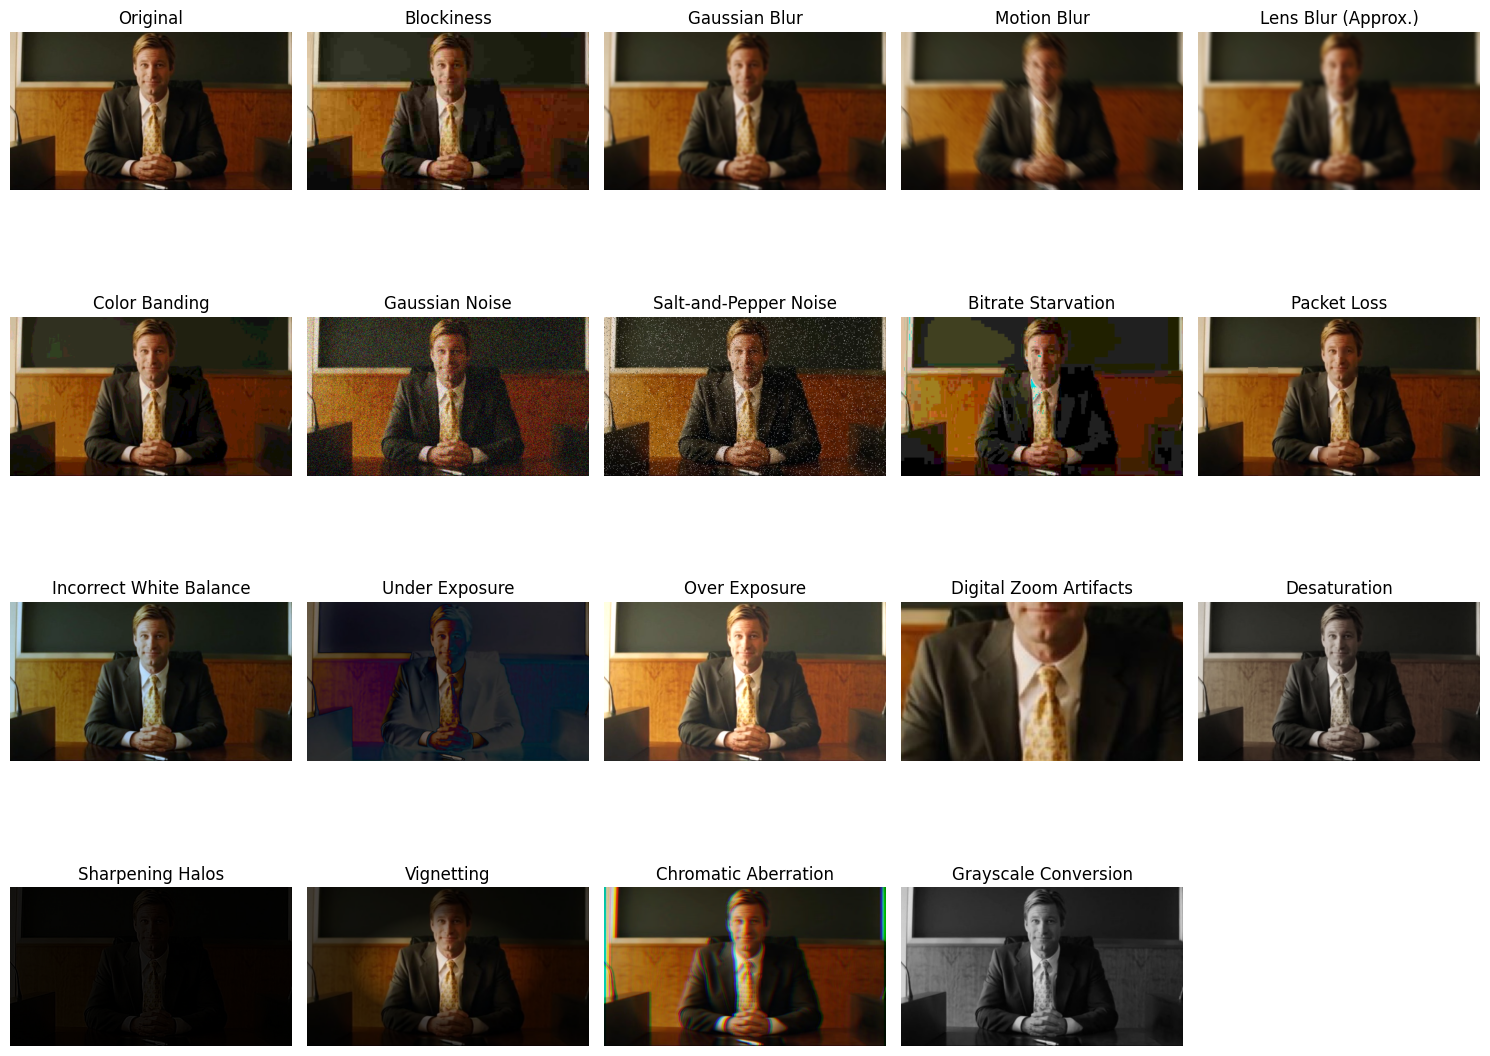


All degraded examples saved to 'degraded_examples' directory and displayed.


In [ ]:
if __name__ == "__main__":
    # Replace with your actual image path
    sample_image_path = "/content/thank-you-for-smoking-eckhart-main.jpg"

    if not os.path.exists(sample_image_path):
        print(f"Sample image not found at '{sample_image_path}'. Please update the path.")
    else:
        original_img = load_image(sample_image_path)
        if original_img is None:
            exit()

        output_dir = "degraded_examples"
        os.makedirs(output_dir, exist_ok=True)

        print("\nApplying degradations and saving examples...")

        # List of degradation functions and their display names/parameters
        degradation_funcs = [
            (apply_blockiness_macroblocking, "Blockiness", {"jpeg_quality": 15}, "1_blockiness.jpg"),
            (apply_blurring, "Gaussian Blur", {"blur_type": "gaussian", "ksize": (9, 9), "sigmaX": 2}, "2a_blur_gaussian.jpg"),
            (apply_blurring, "Motion Blur", {"blur_type": "motion", "angle": 45, "length": 20}, "2b_blur_motion.jpg"),
            (apply_blurring, "Lens Blur (Approx.)", {"blur_type": "lens", "ksize": (15, 15), "sigmaX": 5}, "2c_blur_lens.jpg"),
            (apply_color_banding, "Color Banding", {"quantization_levels": 16}, "3_color_banding.jpg"),
            (add_noise, "Gaussian Noise", {"noise_type": "gaussian", "std": 40}, "4a_noise_gaussian.jpg"),
            (add_noise, "Salt-and-Pepper Noise", {"noise_type": "s_p", "amount": 0.02}, "4b_noise_sp.jpg"),
            (apply_bitrate_starvation_effects, "Bitrate Starvation", {"aggressive_jpeg_quality": 10, "aggressive_color_quantization": 8}, "5_bitrate_starvation.jpg"),
            (simulate_packet_loss, "Packet Loss", {"block_size": 24, "loss_probability": 0.08, "fill_mode": "blur"}, "6_packet_loss.jpg"),
            (adjust_white_balance, "Incorrect White Balance", {"red_gain": 0.8, "green_gain": 1.0, "blue_gain": 1.2}, "7_incorrect_wb.jpg"),
            (adjust_exposure, "Under Exposure", {"alpha": 0.7, "beta": -50}, "8a_under_exposure.jpg"),
            (adjust_exposure, "Over Exposure", {"alpha": 1.2, "beta": 30}, "8b_over_exposure.jpg"),
            (apply_digital_zoom_artifacts, "Digital Zoom Artifacts", {"zoom_factor": 2.5, "interpolation_method": cv2.INTER_NEAREST}, "9_digital_zoom.jpg"),
            (apply_desaturation, "Desaturation", {"saturation_factor": 0.3}, "10_desaturation.jpg"),
            (apply_sharpening_halos, "Sharpening Halos", {"strength": 0.8}, "11_sharpening_halos.jpg"),
            (apply_vignetting, "Vignetting", {"strength": 0.7, "radius_factor": 0.7}, "12_vignetting.jpg"),
            (apply_chromatic_aberration, "Chromatic Aberration", {"shift_amount": 5}, "13_chromatic_aberration.jpg"),
            (apply_grayscale_conversion, "Grayscale Conversion", {}, "14_grayscale.jpg")
        ]

        # Calculate number of rows and columns for the plot
        num_images = len(degradation_funcs) + 1 # +1 for original image
        cols = 5
        rows = (num_images + cols - 1) // cols # Ceiling division

        plt.figure(figsize=(cols * 3, rows * 3)) # Adjust figure size based on grid

        # Display Original Image
        plt.subplot(rows, cols, 1)
        plt.title("Original")
        plt.imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
        plt.axis('off')

        # Display Degraded Images
        for i, (func, title, params, filename) in enumerate(degradation_funcs):
            print(f"Applying: {title}")
            degraded_img = func(original_img, **params)

            # Save the degraded image
            save_image(degraded_img, os.path.join(output_dir, filename))

            # Display in subplot
            plt.subplot(rows, cols, i + 2) # +2 because 1st subplot is original
            plt.title(title)
            # Convert BGR to RGB for matplotlib display
            plt.imshow(cv2.cvtColor(degraded_img, cv2.COLOR_BGR2RGB))
            plt.axis('off')

        plt.tight_layout()
        plt.show()

        print(f"\nAll degraded examples saved to '{output_dir}' directory and displayed.")

In [ ]:
# Step 2 : Grouping and application on single Picture


🔀 Sequential Mode: Apply one group after another for cumulative effect.

🎲 Random Mode: Randomly select one or more degradations from each group.

🌈 Weighted Severity: Control intensity per group (e.g., strong blur + mild noise + moderate compression).

In [ ]:
# Load an image
image = cv2.imread('input.jpg')

# Apply a sequence of degradations
degraded = apply_blurring(image, blur_type="gaussian", ksize=(15, 15), sigmaX=5)
degraded = apply_color_banding(degraded, quantization_levels=16)
degraded = add_noise(degraded, noise_type="gaussian", mean=0, std=25)
degraded = adjust_exposure(degraded, alpha=1.2, beta=10)
degraded = apply_vignetting(degraded, strength=0.4, radius_factor=0.7)

# Save the degraded image
cv2.imwrite('degraded.jpg', degraded)

error: OpenCV(4.12.0) /io/opencv/modules/imgproc/src/smooth.dispatch.cpp:618: error: (-215:Assertion failed) !_src.empty() in function 'GaussianBlur'


In [ ]:
import cv2
import numpy as np
from PIL import Image, ImageEnhance
import random

# Load image
image = cv2.imread('/content/drive/MyDrive/1542258.jpg')
image = cv2.resize(image, (512, 512))

# Create output directory
output_dir = 'output_try'
os.makedirs(output_dir, exist_ok=True)


# -------------------- Group A: Acquisition & Sensor Defects --------------------
def apply_group_A(img):
    """Applies degradations related to image acquisition and sensor defects."""
    degraded_img = img.copy()

    # Incorrect White Balance (using LAB color space for tint adjustments)
    lab = cv2.cvtColor(degraded_img, cv2.COLOR_BGR2LAB)
    lab = lab.astype(np.float32) # Convert to float for calculations
    # Adjust a* (green-red) and b* (blue-yellow) channels
    lab[:, :, 1] = lab[:, :, 1] * 1.2  # More red/less green
    lab[:, :, 2] = lab[:, :, 2] * 0.8  # More blue/less yellow
    lab = np.clip(lab, 0, 255).astype(np.uint8) # Clip and convert back
    degraded_img = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)


    # Under Exposure (applied after WB for compounding effect)
    degraded_img = cv2.convertScaleAbs(degraded_img, alpha=0.6, beta=0)

    # Over Exposure (applied after WB and Under Exposure)
    degraded_img = cv2.convertScaleAbs(degraded_img, alpha=1.5, beta=30)

    # Vignetting
    rows, cols = degraded_img.shape[:2]
    # Create Gaussian kernels for X and Y axes
    kernel_x = cv2.getGaussianKernel(cols, cols * 0.4)
    kernel_y = cv2.getGaussianKernel(rows, rows * 0.4)
    # Create 2D Gaussian kernel by multiplying the 1D kernels
    kernel = kernel_y * kernel_x.T
    # Normalize the kernel to create a mask
    mask = kernel / kernel.max()

    # Apply the mask to each color channel
    degraded_img = degraded_img.astype(np.float32) # Convert image to float
    for i in range(3):
        degraded_img[:, :, i] = degraded_img[:, :, i] * mask
    degraded_img = np.clip(degraded_img, 0, 255).astype(np.uint8) # Clip and convert back

    # Chromatic Aberration
    b, g, r = cv2.split(degraded_img)
    # Shift red channel
    r_shifted = np.zeros_like(r)
    shift_amount = 5
    r_shifted[:, shift_amount:] = r[:, :-shift_amount] # Shift right

    # Shift blue channel
    b_shifted = np.zeros_like(b)
    b_shifted[:, :-shift_amount] = b[:, shift_amount:] # Shift left

    degraded_img = cv2.merge([b_shifted, g, r_shifted])

    return degraded_img

# -------------------- Group B: Transmission & Compression Artifacts --------------------
def apply_group_B(img):
    """Applies degradations related to transmission and compression artifacts."""
    degraded_img = img.copy()

    # Blockiness (Simulated via aggressive downsampling and upsampling with nearest neighbor)
    degraded_img = cv2.resize(degraded_img, (64, 64), interpolation=cv2.INTER_NEAREST)
    degraded_img = cv2.resize(degraded_img, (512, 512), interpolation=cv2.INTER_NEAREST)

    # Bitrate Starvation (Aggressive JPEG compression)
    encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), 10]
    _, encimg = cv2.imencode('.jpg', degraded_img, encode_param)
    degraded_img = cv2.imdecode(encimg, 1)

    # Packet Loss (Simulated by blacking out random blocks)
    rows, cols = degraded_img.shape[:2]
    block_size = 32
    loss_probability = 0.05
    for y in range(0, rows, block_size):
        for x in range(0, cols, block_size):
            if random.random() < loss_probability:
                degraded_img[y:y+block_size, x:x+block_size] = 0 # Black block

    # Color Banding (Quantizing color levels)
    # Convert to float for calculations
    degraded_img = degraded_img.astype(np.float32)
    # Divide by step size, round, then multiply back
    step = 256 // 16 # 16 levels
    degraded_img = (np.round(degraded_img / step) * step)
    # Clip and convert back to uint8
    degraded_img = np.clip(degraded_img, 0, 255).astype(np.uint8)

    return degraded_img

# -------------------- Group C: Blurring Effects --------------------
def apply_group_C(img):
    """Applies various blurring effects."""
    degraded_img = img.copy()

    # Gaussian Blur
    degraded_img = cv2.GaussianBlur(degraded_img, (15, 15), sigmaX=5)

    # Motion Blur
    size = 15
    # Create a horizontal motion blur kernel
    kernel = np.zeros((size, size), dtype=np.float32)
    kernel[int((size-1)/2), :] = np.ones(size, dtype=np.float32)
    kernel /= size # Normalize the kernel
    degraded_img = cv2.filter2D(degraded_img, -1, kernel)

    # Lens Blur (Approximation using a masked Gaussian blur)
    rows, cols = degraded_img.shape[:2]
    mask = np.zeros_like(degraded_img)
    # Create a circular mask (white circle on black background)
    cv2.circle(mask, (cols//2, rows//2), min(rows, cols)//2 - 50, (255, 255, 255), -1)
    # Apply strong Gaussian blur to the original image
    blurred = cv2.GaussianBlur(img, (21, 21), 0)
    # Combine original image where mask is white, and blurred image where mask is black
    # Need to ensure dtypes are compatible for the boolean operation
    mask_bool = mask == 255
    degraded_img = np.where(mask_bool, degraded_img, blurred)

    return degraded_img

# -------------------- Group D: Noise Injection --------------------
def apply_group_D(img):
    """Adds various types of noise."""
    degraded_img = img.copy()
    rows, cols, ch = degraded_img.shape

    # Gaussian Noise
    mean = 0
    std = 25
    gauss = np.random.normal(mean, std, (rows, cols, ch)).astype(np.float32)
    noisy_img = degraded_img.astype(np.float32) + gauss
    degraded_img = np.clip(noisy_img, 0, 255).astype(np.uint8)


    # Salt-and-Pepper Noise
    s_vs_p = 0.5 # Ratio of salt vs pepper
    amount = 0.02 # Proportion of pixels to affect
    # Salt mode
    num_salt = np.ceil(amount * degraded_img.size * s_vs_p)
    coords = [np.random.randint(0, i - 1, int(num_salt)) for i in degraded_img.shape[:2]]
    degraded_img[coords[0], coords[1]] = 255 # Set pixel to white

    # Pepper mode
    num_pepper = np.ceil(amount * degraded_img.size * (1. - s_vs_p))
    coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in degraded_img.shape[:2]]
    degraded_img[coords[0], coords[1]] = 0 # Set pixel to black

    return degraded_img

# -------------------- Group E: Resolution Loss & Enhancements --------------------
def apply_group_E(img):
    """Applies resolution loss and sharpening."""
    degraded_img = img.copy()

    # Simulated resolution loss (downsampling and upsampling)
    degraded_img = cv2.resize(degraded_img, None, fx=0.5, fy=0.5, interpolation=cv2.INTER_AREA)
    degraded_img = cv2.resize(degraded_img, (512, 512), interpolation=cv2.INTER_LINEAR)

    # Sharpening (can introduce halos)
    kernel = np.array([[0, -1, 0], [-1, 5,-1], [0, -1, 0]])
    degraded_img = cv2.filter2D(degraded_img, -1, kernel)

    return degraded_img

# -------------------- Group F: Post-processing & Color Alteration --------------------
def apply_group_F(img):
    """Applies post-processing effects like desaturation and grayscale."""
    degraded_img = img.copy()

    # Desaturation (using HSV color space)
    hsv = cv2.cvtColor(degraded_img, cv2.COLOR_BGR2HSV)
    hsv = hsv.astype(np.float32) # Convert to float for calculations
    hsv[:, :, 1] *= 0.3 # Reduce saturation channel
    hsv = np.clip(hsv, 0, 255).astype(np.uint8) # Clip and convert back
    degraded_img = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

    # Grayscale Conversion
    gray = cv2.cvtColor(degraded_img, cv2.COLOR_BGR2GRAY)
    degraded_img = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR) # Convert back to BGR for consistency

    return degraded_img

# Apply and save after each group
degraded = apply_group_A(image)
cv2.imwrite(f'{output_dir}/group_A.jpg', degraded)

degraded = apply_group_B(degraded)
cv2.imwrite(f'{output_dir}/group_B.jpg', degraded)

degraded = apply_group_C(degraded)
cv2.imwrite(f'{output_dir}/group_C.jpg', degraded)

degraded = apply_group_D(degraded)
cv2.imwrite(f'{output_dir}/group_D.jpg', degraded)

degraded = apply_group_E(degraded)
cv2.imwrite(f'{output_dir}/group_E.jpg', degraded)

degraded = apply_group_F(degraded)
cv2.imwrite(f'{output_dir}/group_F.jpg', degraded)

print("✅ All group outputs saved in 'output_try' directory.")

In [ ]:
!zip -r folder_name.zip /content/output_try_Sequential_output

In [ ]:
!zip -r folder_name.zip /content/outputs

In [ ]:
# Random Mode  :

import cv2
import numpy as np
import os
import random

# Load and resize image
image = cv2.imread('/content/drive/MyDrive/1542258.jpg')
image = cv2.resize(image, (512, 512))

# Create output directory
output_dir = 'output_try'
os.makedirs(output_dir, exist_ok=True)

# -------------------- Group A --------------------
def random_group_A(img):
    degraded = img.copy()
    if random.choice([True, False]):
        lab = cv2.cvtColor(degraded, cv2.COLOR_BGR2LAB).astype(np.float32)
        lab[:, :, 1] *= random.uniform(1.1, 1.3)
        lab[:, :, 2] *= random.uniform(0.7, 0.9)
        degraded = cv2.cvtColor(np.clip(lab, 0, 255).astype(np.uint8), cv2.COLOR_LAB2BGR)
    if random.choice([True, False]):
        degraded = cv2.convertScaleAbs(degraded, alpha=random.uniform(0.5, 0.7), beta=0)
    if random.choice([True, False]):
        degraded = cv2.convertScaleAbs(degraded, alpha=random.uniform(1.4, 1.6), beta=30)
    if random.choice([True, False]):
        rows, cols = degraded.shape[:2]
        kx = cv2.getGaussianKernel(cols, cols * 0.4)
        ky = cv2.getGaussianKernel(rows, rows * 0.4)
        mask = (ky * kx.T) / np.max(ky * kx.T)
        for i in range(3):
            degraded[:, :, i] = degraded[:, :, i] * mask
    if random.choice([True, False]):
        b, g, r = cv2.split(degraded)
        shift = random.randint(3, 7)
        r[:, shift:] = r[:, :-shift]
        b[:, :-shift] = b[:, shift:]
        degraded = cv2.merge([b, g, r])
    return degraded

# -------------------- Group B --------------------
def random_group_B(img):
    degraded = img.copy()
    if random.choice([True, False]):
        degraded = cv2.resize(degraded, (64, 64), interpolation=cv2.INTER_NEAREST)
        degraded = cv2.resize(degraded, (512, 512), interpolation=cv2.INTER_NEAREST)
    if random.choice([True, False]):
        _, encimg = cv2.imencode('.jpg', degraded, [int(cv2.IMWRITE_JPEG_QUALITY), 10])
        degraded = cv2.imdecode(encimg, 1)
    if random.choice([True, False]):
        for _ in range(random.randint(5, 15)):
            x, y = np.random.randint(0, 512, 2)
            w, h = np.random.randint(10, 50, 2)
            degraded[y:y+h, x:x+w] = 0
    if random.choice([True, False]):
        step = 256 // 16
        degraded = (np.round(degraded.astype(np.float32) / step) * step).clip(0, 255).astype(np.uint8)
    return degraded

# -------------------- Group C --------------------
def random_group_C(img):
    degraded = img.copy()
    if random.choice([True, False]):
        degraded = cv2.GaussianBlur(degraded, (15, 15), sigmaX=5)
    if random.choice([True, False]):
        kernel = np.zeros((15, 15), dtype=np.float32)
        kernel[7, :] = 1
        kernel /= 15
        degraded = cv2.filter2D(degraded, -1, kernel)
    if random.choice([True, False]):
        mask = np.zeros_like(degraded)
        cv2.circle(mask, (256, 256), 200, (255, 255, 255), -1)
        blurred = cv2.GaussianBlur(degraded, (21, 21), 0)
        degraded = np.where(mask == 255, degraded, blurred)
    return degraded

# -------------------- Group D --------------------
def random_group_D(img):
    degraded = img.copy()
    if random.choice([True, False]):
        gauss = np.random.normal(0, 25, degraded.shape).astype(np.float32)
        degraded = np.clip(degraded.astype(np.float32) + gauss, 0, 255).astype(np.uint8)
    if random.choice([True, False]):
        s_vs_p = 0.5
        amount = 0.02
        num_salt = int(amount * degraded.size * s_vs_p)
        coords = [np.random.randint(0, i - 1, num_salt) for i in degraded.shape[:2]]
        degraded[coords[0], coords[1]] = 255
        num_pepper = int(amount * degraded.size * (1. - s_vs_p))
        coords = [np.random.randint(0, i - 1, num_pepper) for i in degraded.shape[:2]]
        degraded[coords[0], coords[1]] = 0
    return degraded

# -------------------- Group E --------------------
def random_group_E(img):
    degraded = img.copy()
    if random.choice([True, False]):
        degraded = cv2.resize(degraded, None, fx=0.5, fy=0.5, interpolation=cv2.INTER_AREA)
        degraded = cv2.resize(degraded, (512, 512), interpolation=cv2.INTER_LINEAR)
    if random.choice([True, False]):
        kernel = np.array([[0, -1, 0], [-1, 5,-1], [0, -1, 0]])
        degraded = cv2.filter2D(degraded, -1, kernel)
    return degraded

# -------------------- Group F --------------------
def random_group_F(img):
    degraded = img.copy()
    if random.choice([True, False]):
        hsv = cv2.cvtColor(degraded, cv2.COLOR_BGR2HSV).astype(np.float32)
        hsv[:, :, 1] *= 0.3
        degraded = cv2.cvtColor(np.clip(hsv, 0, 255).astype(np.uint8), cv2.COLOR_HSV2BGR)
    if random.choice([True, False]):
        gray = cv2.cvtColor(degraded, cv2.COLOR_BGR2GRAY)
        degraded = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
    return degraded

# Apply random degradations
degraded = random_group_A(image)
degraded = random_group_B(degraded)
degraded = random_group_C(degraded)
degraded = random_group_D(degraded)
degraded = random_group_E(degraded)
degraded = random_group_F(degraded)

# Save final output
cv2.imwrite(f'{output_dir}/random_mode_output.jpg', degraded)
print("🎲 Random mode degradation complete. Image saved in 'output_try'.")


In [ ]:
import cv2
import numpy as np
import os
import random

# Load and resize image
image = cv2.imread('/content/drive/MyDrive/1542258.jpg')
image = cv2.resize(image, (512, 512))

# Create output directory
output_dir = 'output_try_random'
os.makedirs(output_dir, exist_ok=True)

# Initialize log list
applied_degradations = []

# -------------------- Group A --------------------
def random_group_A(img):
    degraded = img.copy()
    if random.choice([True, False]):
        lab = cv2.cvtColor(degraded, cv2.COLOR_BGR2LAB).astype(np.float32)
        lab[:, :, 1] *= random.uniform(1.1, 1.3)
        lab[:, :, 2] *= random.uniform(0.7, 0.9)
        degraded = cv2.cvtColor(np.clip(lab, 0, 255).astype(np.uint8), cv2.COLOR_LAB2BGR)
        applied_degradations.append("Incorrect White Balance")
    if random.choice([True, False]):
        degraded = cv2.convertScaleAbs(degraded, alpha=random.uniform(0.5, 0.7), beta=0)
        applied_degradations.append("Under Exposure")
    if random.choice([True, False]):
        degraded = cv2.convertScaleAbs(degraded, alpha=random.uniform(1.4, 1.6), beta=30)
        applied_degradations.append("Over Exposure")
    if random.choice([True, False]):
        rows, cols = degraded.shape[:2]
        kx = cv2.getGaussianKernel(cols, cols * 0.4)
        ky = cv2.getGaussianKernel(rows, rows * 0.4)
        mask = (ky * kx.T) / np.max(ky * kx.T)
        for i in range(3):
            degraded[:, :, i] = degraded[:, :, i] * mask
        applied_degradations.append("Vignetting")
    if random.choice([True, False]):
        b, g, r = cv2.split(degraded)
        shift = random.randint(3, 7)
        r[:, shift:] = r[:, :-shift]
        b[:, :-shift] = b[:, shift:]
        degraded = cv2.merge([b, g, r])
        applied_degradations.append("Chromatic Aberration")
    return degraded

# -------------------- Group B --------------------
def random_group_B(img):
    degraded = img.copy()
    if random.choice([True, False]):
        degraded = cv2.resize(degraded, (64, 64), interpolation=cv2.INTER_NEAREST)
        degraded = cv2.resize(degraded, (512, 512), interpolation=cv2.INTER_NEAREST)
        applied_degradations.append("Blockiness")
    if random.choice([True, False]):
        _, encimg = cv2.imencode('.jpg', degraded, [int(cv2.IMWRITE_JPEG_QUALITY), 10])
        degraded = cv2.imdecode(encimg, 1)
        applied_degradations.append("Bitrate Starvation")
    if random.choice([True, False]):
        for _ in range(random.randint(5, 15)):
            x, y = np.random.randint(0, 512, 2)
            w, h = np.random.randint(10, 50, 2)
            degraded[y:y+h, x:x+w] = 0
        applied_degradations.append("Packet Loss")
    if random.choice([True, False]):
        step = 256 // 16
        degraded = (np.round(degraded.astype(np.float32) / step) * step).clip(0, 255).astype(np.uint8)
        applied_degradations.append("Color Banding")
    return degraded

# -------------------- Group C --------------------
def random_group_C(img):
    degraded = img.copy()
    if random.choice([True, False]):
        degraded = cv2.GaussianBlur(degraded, (15, 15), sigmaX=5)
        applied_degradations.append("Gaussian Blur")
    if random.choice([True, False]):
        kernel = np.zeros((15, 15), dtype=np.float32)
        kernel[7, :] = 1
        kernel /= 15
        degraded = cv2.filter2D(degraded, -1, kernel)
        applied_degradations.append("Motion Blur")
    if random.choice([True, False]):
        mask = np.zeros_like(degraded)
        cv2.circle(mask, (256, 256), 200, (255, 255, 255), -1)
        blurred = cv2.GaussianBlur(degraded, (21, 21), 0)
        degraded = np.where(mask == 255, degraded, blurred)
        applied_degradations.append("Lens Blur")
    return degraded

# -------------------- Group D --------------------
def random_group_D(img):
    degraded = img.copy()
    if random.choice([True, False]):
        gauss = np.random.normal(0, 25, degraded.shape).astype(np.float32)
        degraded = np.clip(degraded.astype(np.float32) + gauss, 0, 255).astype(np.uint8)
        applied_degradations.append("Gaussian Noise")
    if random.choice([True, False]):
        s_vs_p = 0.5
        amount = 0.02
        num_salt = int(amount * degraded.size * s_vs_p)
        coords = [np.random.randint(0, i - 1, num_salt) for i in degraded.shape[:2]]
        degraded[coords[0], coords[1]] = 255
        num_pepper = int(amount * degraded.size * (1. - s_vs_p))
        coords = [np.random.randint(0, i - 1, num_pepper) for i in degraded.shape[:2]]
        degraded[coords[0], coords[1]] = 0
        applied_degradations.append("Salt-and-Pepper Noise")
    return degraded

# -------------------- Group E --------------------
def random_group_E(img):
    degraded = img.copy()
    if random.choice([True, False]):
        degraded = cv2.resize(degraded, None, fx=0.5, fy=0.5, interpolation=cv2.INTER_AREA)
        degraded = cv2.resize(degraded, (512, 512), interpolation=cv2.INTER_LINEAR)
        applied_degradations.append("Digital Zoom Artifacts")
    if random.choice([True, False]):
        kernel = np.array([[0, -1, 0], [-1, 5,-1], [0, -1, 0]])
        degraded = cv2.filter2D(degraded, -1, kernel)
        applied_degradations.append("Sharpening Halos")
    return degraded

# -------------------- Group F --------------------
def random_group_F(img):
    degraded = img.copy()
    if random.choice([True, False]):
        hsv = cv2.cvtColor(degraded, cv2.COLOR_BGR2HSV).astype(np.float32)
        hsv[:, :, 1] *= 0.3
        degraded = cv2.cvtColor(np.clip(hsv, 0, 255).astype(np.uint8), cv2.COLOR_HSV2BGR)
        applied_degradations.append("Desaturation")
    if random.choice([True, False]):
        gray = cv2.cvtColor(degraded, cv2.COLOR_BGR2GRAY)
        degraded = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
        applied_degradations.append("Grayscale Conversion")
    return degraded

# Apply random degradations
degraded = random_group_A(image)
degraded = random_group_B(degraded)
degraded = random_group_C(degraded)
degraded = random_group_D(degraded)
degraded = random_group_E(degraded)
degraded = random_group_F(degraded)

# Save final output
cv2.imwrite(f'{output_dir}/random_mode_output.jpg', degraded)

# Save degradation log
log_path = os.path.join(output_dir, 'degradations_log.txt')
with open(log_path, 'w') as f:
    for item in applied_degradations:
        f.write(item + '\n')

print("✅ Random mode complete. Image and log saved in 'output_try'.")


In [ ]:
!zip -r random_output1.zip /content/output_try_random_1

In [ ]:

!zip -r random_output4.zip /content/output_try_random_4
!zip -r random_output5.zip /content/output_try_random_5

In [ ]:
# Wtd severity

import cv2
import numpy as np
import os

# Load and resize image
image = cv2.imread('/content/drive/MyDrive/1542258.jpg')
image = cv2.resize(image, (512, 512))

# Create output directory
output_dir = 'output_try_wtd_sev'
os.makedirs(output_dir, exist_ok=True)

# Initialize log
severity_log = []

# -------------------- Group A --------------------
def apply_group_A(img, wb_strength=1.2, under_exp=0.6, over_exp=1.5, vignette_strength=0.4, chrom_ab_shift=5):
    degraded = img.copy()
    # White Balance
    lab = cv2.cvtColor(degraded, cv2.COLOR_BGR2LAB).astype(np.float32)
    lab[:, :, 1] *= wb_strength
    lab[:, :, 2] *= (2 - wb_strength)
    degraded = cv2.cvtColor(np.clip(lab, 0, 255).astype(np.uint8), cv2.COLOR_LAB2BGR)
    severity_log.append(f"White Balance Strength: {wb_strength}")

    # Under Exposure
    degraded = cv2.convertScaleAbs(degraded, alpha=under_exp, beta=0)
    severity_log.append(f"Under Exposure Alpha: {under_exp}")

    # Over Exposure
    degraded = cv2.convertScaleAbs(degraded, alpha=over_exp, beta=30)
    severity_log.append(f"Over Exposure Alpha: {over_exp}")

    # Vignetting
    rows, cols = degraded.shape[:2]
    kx = cv2.getGaussianKernel(cols, cols * vignette_strength)
    ky = cv2.getGaussianKernel(rows, rows * vignette_strength)
    mask = (ky * kx.T) / np.max(ky * kx.T)
    for i in range(3):
        degraded[:, :, i] = degraded[:, :, i] * mask
    severity_log.append(f"Vignetting Strength: {vignette_strength}")

    # Chromatic Aberration
    b, g, r = cv2.split(degraded)
    r[:, chrom_ab_shift:] = r[:, :-chrom_ab_shift]
    b[:, :-chrom_ab_shift] = b[:, chrom_ab_shift:]
    degraded = cv2.merge([b, g, r])
    severity_log.append(f"Chromatic Aberration Shift: {chrom_ab_shift}")
    return degraded

# -------------------- Group B --------------------
def apply_group_B(img, jpeg_quality=10, packet_loss_prob=0.05, banding_levels=16):
    degraded = img.copy()
    # Blockiness
    degraded = cv2.resize(degraded, (64, 64), interpolation=cv2.INTER_NEAREST)
    degraded = cv2.resize(degraded, (512, 512), interpolation=cv2.INTER_NEAREST)
    severity_log.append("Blockiness Applied")

    # Bitrate Starvation
    _, encimg = cv2.imencode('.jpg', degraded, [int(cv2.IMWRITE_JPEG_QUALITY), jpeg_quality])
    degraded = cv2.imdecode(encimg, 1)
    severity_log.append(f"JPEG Quality: {jpeg_quality}")

    # Packet Loss
    block_size = 32
    for y in range(0, degraded.shape[0], block_size):
        for x in range(0, degraded.shape[1], block_size):
            if np.random.rand() < packet_loss_prob:
                degraded[y:y+block_size, x:x+block_size] = 0
    severity_log.append(f"Packet Loss Probability: {packet_loss_prob}")

    # Color Banding
    step = 256 // banding_levels
    degraded = (np.round(degraded.astype(np.float32) / step) * step).clip(0, 255).astype(np.uint8)
    severity_log.append(f"Color Banding Levels: {banding_levels}")
    return degraded

# -------------------- Group C --------------------
def apply_group_C(img, blur_ksize=15, motion_strength=15, lens_blur_radius=200):
    degraded = img.copy()
    # Gaussian Blur
    degraded = cv2.GaussianBlur(degraded, (blur_ksize, blur_ksize), sigmaX=5)
    severity_log.append(f"Gaussian Blur Kernel Size: {blur_ksize}")

    # Motion Blur
    kernel = np.zeros((motion_strength, motion_strength), dtype=np.float32)
    kernel[motion_strength//2, :] = 1
    kernel /= motion_strength
    degraded = cv2.filter2D(degraded, -1, kernel)
    severity_log.append(f"Motion Blur Strength: {motion_strength}")

    # Lens Blur
    mask = np.zeros_like(degraded)
    cv2.circle(mask, (256, 256), lens_blur_radius, (255, 255, 255), -1)
    blurred = cv2.GaussianBlur(degraded, (21, 21), 0)
    degraded = np.where(mask == 255, degraded, blurred)
    severity_log.append(f"Lens Blur Radius: {lens_blur_radius}")
    return degraded

# -------------------- Group D --------------------
def apply_group_D(img, gauss_std=15, sp_amount=0.01):
    degraded = img.copy()
    # Gaussian Noise
    gauss = np.random.normal(0, gauss_std, degraded.shape).astype(np.float32)
    degraded = np.clip(degraded.astype(np.float32) + gauss, 0, 255).astype(np.uint8)
    severity_log.append(f"Gaussian Noise Std Dev: {gauss_std}")

    # Salt-and-Pepper Noise
    s_vs_p = 0.5
    num_salt = int(sp_amount * degraded.size * s_vs_p)
    coords = [np.random.randint(0, i - 1, num_salt) for i in degraded.shape[:2]]
    degraded[coords[0], coords[1]] = 255
    num_pepper = int(sp_amount * degraded.size * (1. - s_vs_p))
    coords = [np.random.randint(0, i - 1, num_pepper) for i in degraded.shape[:2]]
    degraded[coords[0], coords[1]] = 0
    severity_log.append(f"Salt-and-Pepper Noise Amount: {sp_amount}")
    return degraded

# -------------------- Group E --------------------
def apply_group_E(img, zoom_factor=0.5, sharpen_strength=1.0):
    degraded = img.copy()
    # Digital Zoom
    degraded = cv2.resize(degraded, None, fx=zoom_factor, fy=zoom_factor, interpolation=cv2.INTER_AREA)
    degraded = cv2.resize(degraded, (512, 512), interpolation=cv2.INTER_LINEAR)
    severity_log.append(f"Zoom Factor: {zoom_factor}")

    # Sharpening
    kernel = np.array([[0, -1, 0], [-1, 5 * sharpen_strength, -1], [0, -1, 0]])
    degraded = cv2.filter2D(degraded, -1, kernel)
    severity_log.append(f"Sharpening Strength: {sharpen_strength}")
    return degraded

# -------------------- Group F --------------------
def apply_group_F(img, desaturation_level=0.3, grayscale=True):
    degraded = img.copy()
    # Desaturation
    hsv = cv2.cvtColor(degraded, cv2.COLOR_BGR2HSV).astype(np.float32)
    hsv[:, :, 1] *= desaturation_level
    degraded = cv2.cvtColor(np.clip(hsv, 0, 255).astype(np.uint8), cv2.COLOR_HSV2BGR)
    severity_log.append(f"Desaturation Level: {desaturation_level}")

    # Grayscale Conversion
    if grayscale:
        gray = cv2.cvtColor(degraded, cv2.COLOR_BGR2GRAY)
        degraded = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
        severity_log.append("Grayscale Conversion: Enabled")
    return degraded

# Apply all groups with weighted severity
degraded = apply_group_A(image, wb_strength=1.3, under_exp=0.5, over_exp=1.6, vignette_strength=0.5, chrom_ab_shift=6)
degraded = apply_group_B(degraded, jpeg_quality=10, packet_loss_prob=0.03, banding_levels=8)
degraded = apply_group_C(degraded, blur_ksize=17, motion_strength=17, lens_blur_radius=180)

#degraded = apply_group_D(degraded, gauss_std=30, sp_amount=0.03)
degraded = apply_group_D(degraded, gauss_std=15, sp_amount=0.001)


degraded = apply_group_E(degraded, zoom_factor=0.4, sharpen_strength=1)
degraded = apply_group_F(degraded, desaturation_level=0.2, grayscale=True)

# Save final image
cv2.imwrite(f'{output_dir}/weighted_severity_output.jpg', degraded)

# Save severity log
with open(os.path.join(output_dir, 'severity_log.txt'), 'w') as f:
    for entry in severity_log:
        f.write(entry + '\n')

print("🎚️ Weighted severity mode complete. Image and log saved in 'output_try'.")


In [ ]:
!zip -r wtd_sev_output.zip /content/output_try_wtd_sev


In [ ]:
import os
import pandas as pd
from PIL import Image
import io
import base64
import re
import logging

# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Paths
input_parquet = "/content/drive/MyDrive/train-00000-of-00001.parquet"
output_dir = "imgs_datasets"
os.makedirs(output_dir, exist_ok=True)

# Load Parquet file
df = pd.read_parquet(input_parquet)
logging.info(f"Loaded Parquet file with {len(df)} records.")

# Helper to clean label names
def clean_label(label):
    label = re.sub(r'^\d+\s*', '', str(label))  # Remove leading digits
    label = re.sub(r'[<>:"/\\|?*]', '_', label)  # Replace invalid characters
    return label.strip()

# Iterate and save images
for idx, row in df.iterrows():
    raw_label = row['label']
    cleaned_label = clean_label(raw_label)  # ✅ Use cleaned label for folder name
    image_dict = row['image']

    try:
        # Extract image bytes from dictionary
        if isinstance(image_dict, dict):
            if 'data' in image_dict:
                image_bytes = base64.b64decode(image_dict['data'])
            elif 'bytes' in image_dict:
                image_bytes = image_dict['bytes']
            else:
                raise ValueError("Unknown image dict format")
        else:
            raise TypeError("Expected dict in 'image' column")

        # Convert to image
        image = Image.open(io.BytesIO(image_bytes)).convert("RGB")

        # Save to cleaned label-specific folder
        label_dir = os.path.join(output_dir, cleaned_label)
        os.makedirs(label_dir, exist_ok=True)
        image_path = os.path.join(label_dir, f"image_{idx}.jpg")
        image.save(image_path)

        logging.info(f"Saved image {idx} to {label_dir}")

    except Exception as e:
        logging.error(f"Error processing row {idx}: {e}")


In [ ]:
!zip -r datasets.zip /content/imgs_dataset


In [ ]:
import os
import pandas as pd
from PIL import Image
import io
import base64
import re

# Paths
input_parquet = "/content/drive/MyDrive/train-00000-of-00001.parquet"
output_dir = "imgs_dataset4"
os.makedirs(output_dir, exist_ok=True)

# Load parquet file
df = pd.read_parquet(input_parquet)
print("DataFrame loaded.")
print("Rows:", len(df))
print("Columns:", df.columns)
print("Sample rows:\n", df.head())

# Helper: Clean label names
def clean_label(label):
    # Remove leading digits and whitespace
    label = re.sub(r'^\d+\s*', '', str(label))
    # Replace invalid filesystem characters
    label = re.sub(r'[<>:"/\\|?*]', '_', label)
    return label.strip()

# Track if any images are saved
saved_any = False

# Iterate and save images
for idx, row in df.iterrows():
    raw_label = row.get('label')
    if raw_label is None or pd.isna(raw_label):
        print(f"Row {idx} has missing/NaN label, skipping.")
        continue
    label = clean_label(raw_label)
    image_dict = row.get('image')
    try:
        if isinstance(image_dict, dict):
            if 'data' in image_dict and image_dict['data'] is not None:
                image_bytes = base64.b64decode(image_dict['data'])
            elif 'bytes' in image_dict and image_dict['bytes'] is not None:
                image_bytes = image_dict['bytes']
            else:
                raise ValueError("Unknown or empty image dict format")
        else:
            raise TypeError("Expected dict in 'image' column")
        image = Image.open(io.BytesIO(image_bytes)).convert("RGB")
        # Save to folder named after cleaned label
        label_dir = os.path.join(output_dir, label)
        os.makedirs(label_dir, exist_ok=True)
        image_path = os.path.join(label_dir, f"image_{idx}.jpg")
        image.save(image_path)
        print(f"Saved image {idx} to {label_dir}")
        saved_any = True
    except Exception as e:
        print(f"Error processing row {idx}: {e}")

if not saved_any:
    print("No images were saved. Please check your Parquet file structure and data consistency.")


In [ ]:
import pandas as pd
import re

input_parquet = "/content/drive/MyDrive/train-00000-of-00001.parquet"
df = pd.read_parquet(input_parquet)

# Extract unique labels like "0Aaron Eckhart"
unique_labels = df['label'].unique()

# Extract only the textual part (celebrity names) from each label
names = set()
for label in unique_labels:
    label = str(label)
    # Remove the leading digits, whatever they are
    name = re.sub(r'^\d+', '', label).strip()
    names.add(name)

# Convert to sorted list
sorted_names = sorted(names)

# Print results — all celebrity names only
for name in sorted_names:
    print(name)


In [ ]:
from datasets import load_dataset

ds = load_dataset("ares1123/celebrity_dataset")

# 'ds' is a DatasetDict, e.g., with keys ['train'] or ['train', 'test']
print(ds)

# Access a single split Dataset, often 'train'
train_ds = ds['train']

# Now you can use the .take() method on the Dataset split
for example in train_ds.take(5):
    print(example)


In [ ]:
from datasets import load_dataset

ds = load_dataset("ares1123/celebrity_dataset")

print(ds)  # Shows splits, dataset info

# Access train split
train_ds = ds['train']

# The label feature is a ClassLabel with names
print(train_ds.features['label'])  # Should print ClassLabel info with names

# Get the mapping of numeric IDs to names
id2name = train_ds.features['label'].int2str

# Print label names for each numeric ID in the dataset (IDs range 0 to N)
for i in range(train_ds.features['label'].num_classes):
    print(i, train_ds.features['label'].int2str(i))


In [ ]:
import os

# Base directory containing numeric folders
base_dir = "/content/imgs_dataset2"

# Mapping from label number to celebrity name
label_mapping = {
    0: "Aaron Eckhart",
    1: "Aaron Paul",
    2: "Aaron Rodgers",
    3: "Aaron Taylor-Johnson",
    4: "Abbi Jacobson",
    5: "Abhishek Bachchan",
    6: "Abigail Breslin",
    7: "Abigail Spencer",
    8: "Adam Brody",
    9: "Adam Devine",
    10: "Adam Driver",
    11: "Adam Lambert",
    12: "Adam Levine",
    13: "Adam Sandler",
    14: "Adam Scott",
    15: "Adele",
    16: "Adrian Grenier",
    17: "Adèle Exarchopoulos",
    18: "Aidan Gillen",
    19: "Aidan Turner",
    20: "Aishwarya Rai",
    21: "Aja Naomi King",
    22: "Alden Ehrenreich",
    23: "Aldis Hodge",
    24: "Alec Baldwin",
    25: "Alex Morgan",
    26: "Alex Pettyfer",
    27: "Alex Rodriguez",
    28: "Alexander Skarsgård",
    29: "Alexandra Daddario",
    30: "Alfre Woodard",
    31: "Alia Shawkat",
    32: "Alice Braga",
    33: "Alice Eve",
    34: "Alicia Keys",
    35: "Alicia Vikander",
    36: "Alison Brie",
    37: "Allison Janney",
    38: "Allison Williams",
    39: "Alyson Hannigan",
    40: "Amanda Peet",
    41: "Amanda Seyfried",
    42: "Amandla Stenberg",
    43: "Amber Heard",
    44: "America Ferrera",
    45: "Amy Adams",
    46: "Amy Poehler",
    47: "Amy Schumer",
    48: "Ana de Armas",
    49: "Andie MacDowell",
    50: "Andrew Garfield",
    51: "Andrew Lincoln",
    52: "Andrew Scott",
    53: "Andy Garcia",
    54: "Andy Samberg",
    55: "Andy Serkis",
    56: "Angela Bassett",
    57: "Angelina Jolie",
    58: "Anna Camp",
    59: "Anna Faris",
    60: "Anna Kendrick",
    61: "Anna Paquin",
    62: "AnnaSophia Robb",
    63: "Annabelle Wallis",
    64: "Anne Hathaway",
    65: "Anne Marie",
    66: "Anne-Marie",
    67: "Ansel Elgort",
    68: "Anson Mount",
    69: "Anthony Hopkins",
    70: "Anthony Joshua",
    71: "Anthony Mackie",
    72: "Antonio Banderas",
    73: "Anya Taylor-Joy",
    74: "Ariana Grande",
    75: "Armie Hammer",
    76: "Ashley Judd",
    77: "Ashton Kutcher",
    78: "Aubrey Plaza",
    79: "Auli'i Cravalho",
    80: "Awkwafina",
    81: "Barack Obama",
    82: "Bella Hadid",
    83: "Bella Thorne",
    84: "Ben Barnes",
    85: "Ben Mendelsohn",
    86: "Ben Stiller",
    87: "Ben Whishaw",
    88: "Benedict Cumberbatch",
    89: "Benedict Wong",
    90: "Benicio del Toro",
    91: "Bill Gates",
    92: "Bill Hader",
    93: "Bill Murray",
    94: "Bill Pullman",
    95: "Bill Skarsgård",
    96: "Billie Eilish",
    97: "Billie Lourd",
    98: "Billy Crudup",
    99: "Billy Porter",
    100: "Blake Lively",
    101: "Bob Odenkirk",
    102: "Bonnie Wright",
    103: "Boyd Holbrook",
    104: "Brad Pitt",
    105: "Bradley Cooper",
    106: "Brendan Fraser",
    107: "Brian Cox",
    108: "Brie Larson",
    109: "Brittany Snow",
    110: "Bryan Cranston",
    111: "Bryce Dallas Howard",
    112: "Busy Philipps",
    113: "Caitriona Balfe",
    114: "Cameron Diaz",
    115: "Camila Cabello",
    116: "Camila Mendes",
    117: "Cardi B",
    118: "Carey Mulligan",
    119: "Carla Gugino",
    120: "Carrie Underwood",
    121: "Casey Affleck",
    122: "Cate Blanchett",
    123: "Catherine Keener",
    124: "Catherine Zeta-Jones",
    125: "Celine Dion",
    126: "Chace Crawford",
    127: "Chadwick Boseman",
    128: "Channing Tatum",
    129: "Charlie Cox",
    130: "Charlie Day",
    131: "Charlie Hunnam",
    132: "Charlie Plummer",
    133: "Charlize Theron",
    134: "Chiara Ferragni",
    135: "Chiwetel Ejiofor",
    136: "Chloe Bennet",
    137: "Chloe Grace Moretz",
    138: "Chloe Sevigny",
    139: "Chloë Grace Moretz",
    140: "Chloë Sevigny",
    141: "Chris Cooper",
    142: "Chris Evans",
    143: "Chris Hemsworth",
    144: "Chris Martin",
    145: "Chris Messina",
    146: "Chris Noth",
    147: "Chris O'Dowd",
    148: "Chris Pine",
    149: "Chris Pratt",
    150: "Chris Tucker",
    151: "Chrissy Teigen",
    152: "Christian Bale",
    153: "Christian Slater",
    154: "Christina Aguilera",
    155: "Christina Applegate",
    156: "Christina Hendricks",
    157: "Christina Milian",
    158: "Christina Ricci",
    159: "Christine Baranski",
    160: "Christoph Waltz",
    161: "Christopher Plummer",
    162: "Christopher Walken",
    163: "Cillian Murphy",
    164: "Claire Foy",
    165: "Clive Owen",
    166: "Clive Standen",
    167: "Cobie Smulders",
    168: "Colin Farrell",
    169: "Colin Firth",
    170: "Colin Hanks",
    171: "Connie Britton",
    172: "Conor McGregor",
    173: "Constance Wu",
    174: "Constance Zimmer",
    175: "Courteney Cox",
    176: "Cristiano Ronaldo",
    177: "Daisy Ridley",
    178: "Dak Prescott",
    179: "Dakota Fanning",
    180: "Dakota Johnson",
    181: "Damian Lewis",
    182: "Dan Stevens",
    183: "Danai Gurira",
    184: "Dane DeHaan",
    185: "Daniel Craig",
    186: "Daniel Dae Kim",
    187: "Daniel Day-Lewis",
    188: "Daniel Gillies",
    189: "Daniel Kaluuya",
    190: "Daniel Mays",
    191: "Daniel Radcliffe",
    192: "Danny DeVito",
    193: "Darren Criss",
    194: "Dave Bautista",
    195: "Dave Franco",
    196: "Dave Grohl",
    197: "Daveed Diggs",
    198: "David Attenborough",
    199: "David Beckham",
    200: "David Duchovny",
    201: "David Harbour",
    202: "David Oyelowo",
    203: "David Schwimmer",
    204: "David Tennant",
    205: "David Thewlis",
    206: "Dax Shepard",
    207: "Debra Messing",
    208: "Demi Lovato",
    209: "Dennis Quaid",
    210: "Denzel Washington",
    211: "Dermot Mulroney",
    212: "Dev Patel",
    213: "Diane Keaton",
    214: "Diane Kruger",
    215: "Diane Lane",
    216: "Diego Boneta",
    217: "Diego Luna",
    218: "Djimon Hounsou",
    219: "Dolly Parton",
    220: "Domhnall Gleeson",
    221: "Dominic Cooper",
    222: "Dominic Monaghan",
    223: "Dominic West",
    224: "Don Cheadle",
    225: "Donald Glover",
    226: "Donald Sutherland",
    227: "Donald Trump",
    228: "Dua Lipa",
    229: "Dwayne \"The Rock\" Johnson",
    230: "Dwayne Johnson",
    231: "Dylan O'Brien",
    232: "Ed Harris",
    233: "Ed Helms",
    234: "Ed Sheeran",
    235: "Eddie Murphy",
    236: "Eddie Redmayne",
    237: "Edgar Ramirez",
    238: "Edward Norton",
    239: "Eiza Gonzalez",
    240: "Eiza González",
    241: "Elijah Wood",
    242: "Elisabeth Moss",
    243: "Elisha Cuthbert",
    244: "Eliza Coupe",
    245: "Elizabeth Banks",
    246: "Elizabeth Debicki",
    247: "Elizabeth Lail",
    248: "Elizabeth McGovern",
    249: "Elizabeth Moss",
    250: "Elizabeth Olsen",
    251: "Elle Fanning",
    252: "Ellen DeGeneres",
    253: "Ellen Page",
    254: "Ellen Pompeo",
    255: "Ellie Goulding",
    256: "Elon Musk",
    257: "Emile Hirsch",
    258: "Emilia Clarke",
    259: "Emilia Fox",
    260: "Emily Beecham",
    261: "Emily Blunt",
    262: "Emily Browning",
    263: "Emily Deschanel",
    264: "Emily Hampshire",
    265: "Emily Mortimer",
    266: "Emily Ratajkowski",
    267: "Emily VanCamp",
    268: "Emily Watson",
    269: "Emma Bunton",
    270: "Emma Chamberlain",
    271: "Emma Corrin",
    272: "Emma Mackey",
    273: "Emma Roberts",
    274: "Emma Stone",
    275: "Emma Thompson",
    276: "Emma Watson",
    277: "Emmanuelle Chriqui",
    278: "Emmy Rossum",
    279: "Eoin Macken",
    280: "Eric Bana",
    281: "Ethan Hawke",
    282: "Eva Green",
    283: "Eva Longoria",
    284: "Eva Mendes",
    285: "Evan Peters",
    286: "Evan Rachel Wood",
    287: "Evangeline Lilly",
    288: "Ewan McGregor",
    289: "Ezra Miller",
    290: "Felicity Huffman",
    291: "Felicity Jones",
    292: "Finn Wolfhard",
    293: "Florence Pugh",
    294: "Florence Welch",
    295: "Forest Whitaker",
    296: "Freddie Highmore",
    297: "Freddie Prinze Jr.",
    298: "Freema Agyeman",
    299: "Freida Pinto",
    300: "Freya Allan",
    301: "Gabrielle Union",
    302: "Gael Garcia Bernal",
    303: "Gael García Bernal",
    304: "Gal Gadot",
    305: "Garrett Hedlund",
    306: "Gary Oldman",
    307: "Gemma Arterton",
    308: "Gemma Chan",
    309: "Gemma Whelan",
    310: "George Clooney",
    311: "George Lucas",
    312: "Gerard Butler",
    313: "Giancarlo Esposito",
    314: "Giannis Antetokounmpo",
    315: "Gigi Hadid",
    316: "Gillian Anderson",
    317: "Gillian Jacobs",
    318: "Gina Carano",
    319: "Gina Gershon",
    320: "Gina Rodriguez",
    321: "Ginnifer Goodwin",
    322: "Gisele Bundchen",
    323: "Glenn Close",
    324: "Grace Kelly",
    325: "Greg Kinnear",
    326: "Greta Gerwig",
    327: "Greta Scacchi",
    328: "Greta Thunberg",
    329: "Gugu Mbatha-Raw",
    330: "Guy Ritchie",
    331: "Gwen Stefani",
    332: "Gwendoline Christie",
    333: "Gwyneth Paltrow",
    334: "Hafthor Bjornsson",
    335: "Hailee Steinfeld",
    336: "Hailey Bieber",
    337: "Haley Joel Osment",
    338: "Halle Berry",
    339: "Hannah Simone",
    340: "Harrison Ford",
    341: "Harry Styles",
    342: "Harvey Weinstein",
    343: "Hayden Panettiere",
    344: "Hayley Atwell",
    345: "Helen Hunt",
    346: "Helen Mirren",
    347: "Helena Bonham Carter",
    348: "Henry Cavill",
    349: "Henry Golding",
    350: "Hilary Swank",
    351: "Himesh Patel",
    352: "Hozier",
    353: "Hugh Bonneville",
    354: "Hugh Dancy",
    355: "Hugh Grant",
    356: "Hugh Jackman",
    357: "Hugh Laurie",
    358: "Ian Somerhalder",
    359: "Idris Elba",
    360: "Imelda Staunton",
    361: "Imogen Poots",
    362: "Ioan Gruffudd",
    363: "Isabella Rossellini",
    364: "Isabelle Huppert",
    365: "Isla Fisher",
    366: "Issa Rae",
    367: "Iwan Rheon",
    368: "J.K. Rowling",
    369: "J.K. Simmons",
    370: "Jack Black",
    371: "Jack Reynor",
    372: "Jack Whitehall",
    373: "Jackie Chan",
    374: "Jada Pinkett Smith",
    375: "Jaden Smith",
    376: "Jaimie Alexander",
    377: "Jake Gyllenhaal",
    378: "Jake Johnson",
    379: "Jake T. Austin",
    380: "James Cameron",
    381: "James Corden",
    382: "James Franco",
    383: "James Marsden",
    384: "James McAvoy",
    385: "James Norton",
    386: "Jamie Bell",
    387: "Jamie Chung",
    388: "Jamie Dornan",
    389: "Jamie Foxx",
    390: "Jamie Lee Curtis",
    391: "Jamie Oliver",
    392: "Jane Fonda",
    393: "Jane Krakowski",
    394: "Jane Levy",
    395: "Jane Lynch",
    396: "Jane Seymour",
    397: "Janelle Monáe",
    398: "January Jones",
    399: "Jared Leto",
    400: "Jason Bateman",
    401: "Jason Clarke",
    402: "Jason Derulo",
    403: "Jason Isaacs",
    404: "Jason Momoa",
    405: "Jason Mraz",
    406: "Jason Schwartzman",
    407: "Jason Segel",
    408: "Jason Statham",
    409: "Jason Sudeikis",
    410: "Javier Bardem",
    411: "Jay Baruchel",
    412: "Jay-Z",
    413: "Jeff Bezos",
    414: "Jeff Bridges",
    415: "Jeff Daniels",
    416: "Jeff Goldblum",
    417: "Jeffrey Dean Morgan",
    418: "Jeffrey Donovan",
    419: "Jeffrey Wright",
    420: "Jemima Kirke",
    421: "Jenna Coleman",
    422: "Jenna Fischer",
    423: "Jenna Ortega",
    424: "Jennifer Aniston",
    425: "Jennifer Connelly",
    426: "Jennifer Coolidge",
    427: "Jennifer Esposito",
    428: "Jennifer Garner",
    429: "Jennifer Hudson",
    430: "Jennifer Lawrence",
    431: "Jennifer Lopez",
    432: "Jennifer Love Hewitt",
    433: "Jenny Slate",
    434: "Jeremy Irons",
    435: "Jeremy Renner",
    436: "Jeremy Strong",
    437: "Jerry Seinfeld",
    438: "Jesse Eisenberg",
    439: "Jesse Metcalfe",
    440: "Jesse Plemons",
    441: "Jesse Tyler Ferguson",
    442: "Jesse Williams",
    443: "Jessica Alba",
    444: "Jessica Biel",
    445: "Jessica Chastain",
    446: "Jessica Lange",
    447: "Jessie Buckley",
    448: "Jim Carrey",
    449: "Jim Parsons",
    450: "Joan Collins",
    451: "Joan Cusack",
    452: "Joanne Froggatt",
    453: "Joaquin Phoenix",
    454: "Jodie Comer",
    455: "Jodie Foster",
    456: "Joe Jonas",
    457: "Joe Keery",
    458: "Joel Edgerton",
    459: "Joel Kinnaman",
    460: "Joel McHale",
    461: "John Boyega",
    462: "John C. Reilly",
    463: "John Cena",
    464: "John Cho",
    465: "John Cleese",
    466: "John Corbett",
    467: "John David Washington",
    468: "John Goodman",
    469: "John Hawkes",
    470: "John Krasinski",
    471: "John Legend",
    472: "John Leguizamo",
    473: "John Lithgow",
    474: "John Malkovich",
    475: "John Mayer",
    476: "John Mulaney",
    477: "John Oliver",
    478: "John Slattery",
    479: "John Travolta",
    480: "John Turturro",
    481: "Johnny Depp",
    482: "Johnny Knoxville",
    483: "Jon Bernthal",
    484: "Jon Favreau",
    485: "Jon Hamm",
    486: "Jonah Hill",
    487: "Jonathan Groff",
    488: "Jonathan Majors",
    489: "Jonathan Pryce",
    490: "Jonathan Rhys Meyers",
    491: "Jordan Peele",
    492: "Jordana Brewster",
    493: "Joseph Fiennes",
    494: "Joseph Gordon-Levitt",
    495: "Josh Allen",
    496: "Josh Brolin",
    497: "Josh Gad",
    498: "Josh Hartnett",
    499: "Josh Hutcherson",
    500: "Josh Radnor",
    501: "Jude Law",
    502: "Judy Dench",
    503: "Judy Greer",
    504: "Julia Garner",
    505: "Julia Louis-Dreyfus",
    506: "Julia Roberts",
    507: "Julia Stiles",
    508: "Julian Casablancas",
    509: "Julian McMahon",
    510: "Julianna Margulies",
    511: "Julianne Hough",
    512: "Julianne Moore",
    513: "Julianne Nicholson",
    514: "Juliette Binoche",
    515: "Juliette Lewis",
    516: "Juno Temple",
    517: "Jurnee Smollett",
    518: "Justin Bartha",
    519: "Justin Bieber",
    520: "Justin Hartley",
    521: "Justin Herbert",
    522: "Justin Long",
    523: "Justin Theroux",
    524: "Justin Timberlake",
    525: "KJ Apa",
    526: "Kaitlyn Dever",
    527: "Kaley Cuoco",
    528: "Kanye West",
    529: "Karl Urban",
    530: "Kat Dennings",
    531: "Kate Beckinsale",
    532: "Kate Bosworth",
    533: "Kate Hudson",
    534: "Kate Mara",
    535: "Kate Middleton",
    536: "Kate Upton",
    537: "Kate Walsh",
    538: "Kate Winslet",
    539: "Katee Sackhoff",
    540: "Katherine Heigl",
    541: "Katherine Langford",
    542: "Katherine Waterston",
    543: "Kathryn Hahn",
    544: "Katie Holmes",
    545: "Katie McGrath",
    546: "Katy Perry",
    547: "Kaya Scodelario",
    548: "Keanu Reeves",
    549: "Keegan-Michael Key",
    550: "Keira Knightley",
    551: "Keke Palmer",
    552: "Kelly Clarkson",
    553: "Kelly Macdonald",
    554: "Kelly Marie Tran",
    555: "Kelly Reilly",
    556: "Kelly Ripa",
    557: "Kelvin Harrison Jr.",
    558: "Keri Russell",
    559: "Kerry Washington",
    560: "Kevin Bacon",
    561: "Kevin Costner",
    562: "Kevin Hart",
    563: "Kevin Spacey",
    564: "Ki Hong Lee",
    565: "Kiefer Sutherland",
    566: "Kieran Culkin",
    567: "Kiernan Shipka",
    568: "Kim Dickens",
    569: "Kim Kardashian",
    570: "Kirsten Dunst",
    571: "Kit Harington",
    572: "Kourtney Kardashian",
    573: "Kristen Bell",
    574: "Kristen Stewart",
    575: "Kristen Wiig",
    576: "Kristin Davis",
    577: "Krysten Ritter",
    578: "Kyle Chandler",
    579: "Kylie Jenner",
    580: "Kylie Minogue",
    581: "Lady Gaga",
    582: "Lake Bell",
    583: "Lakeith Stanfield",
    584: "Lamar Jackson",
    585: "Lana Del Rey",
    586: "Laura Dern",
    587: "Laura Harrier",
    588: "Laura Linney",
    589: "Laura Prepon",
    590: "Laurence Fishburne",
    591: "Laverne Cox",
    592: "LeBron James",
    593: "Lea Michele",
    594: "Lea Seydoux",
    595: "Lee Pace",
    596: "Leighton Meester",
    597: "Lena Headey",
    598: "Leonardo Da Vinci",
    599: "Leonardo DiCaprio",
    600: "Leslie Mann",
    601: "Leslie Odom Jr.",
    602: "Lewis Hamilton",
    603: "Liam Hemsworth",
    604: "Liam Neeson",
    605: "Lili Reinhart",
    606: "Lily Aldridge",
    607: "Lily Allen",
    608: "Lily Collins",
    609: "Lily James",
    610: "Lily Rabe",
    611: "Lily Tomlin",
    612: "Lin-Manuel Miranda",
    613: "Linda Cardellini",
    614: "Lionel Messi",
    615: "Lisa Bonet",
    616: "Lisa Kudrow",
    617: "Liv Tyler",
    618: "Lizzo",
    619: "Logan Lerman",
    620: "Lorde",
    621: "Lucy Boynton",
    622: "Lucy Hale",
    623: "Lucy Lawless",
    624: "Lucy Liu",
    625: "Luke Evans",
    626: "Luke Perry",
    627: "Luke Wilson",
    628: "Lupita Nyong'o",
    629: "Léa Seydoux",
    630: "Mackenzie Davis",
    631: "Madelaine Petsch",
    632: "Mads Mikkelsen",
    633: "Mae Whitman",
    634: "Maggie Gyllenhaal",
    635: "Maggie Q",
    636: "Maggie Siff",
    637: "Maggie Smith",
    638: "Mahershala Ali",
    639: "Mahira Khan",
    640: "Maisie Richardson-Sellers",
    641: "Maisie Williams",
    642: "Mandy Moore",
    643: "Mandy Patinkin",
    644: "Marc Anthony",
    645: "Margaret Qualley",
    646: "Margot Robbie",
    647: "Maria Sharapova",
    648: "Marion Cotillard",
    649: "Marisa Tomei",
    650: "Mariska Hargitay",
    651: "Mark Hamill",
    652: "Mark Ruffalo",
    653: "Mark Strong",
    654: "Mark Wahlberg",
    655: "Mark Zuckerberg",
    656: "Marlon Brando",
    657: "Martin Freeman",
    658: "Martin Scorsese",
    659: "Mary Elizabeth Winstead",
    660: "Mary J. Blige",
    661: "Mary Steenburgen",
    662: "Mary-Louise Parker",
    663: "Matt Bomer",
    664: "Matt Damon",
    665: "Matt LeBlanc",
    666: "Matt Smith",
    667: "Matthew Fox",
    668: "Matthew Goode",
    669: "Matthew Macfadyen",
    670: "Matthew McConaughey",
    671: "Matthew Perry",
    672: "Matthew Rhys",
    673: "Matthew Stafford",
    674: "Max Minghella",
    675: "Maya Angelou",
    676: "Maya Hawke",
    677: "Maya Rudolph",
    678: "Megan Fox",
    679: "Megan Rapinoe",
    680: "Meghan Markle",
    681: "Mel Gibson",
    682: "Melanie Lynskey",
    683: "Melissa Benoist",
    684: "Melissa McCarthy",
    685: "Melonie Diaz",
    686: "Meryl Streep",
    687: "Mia Wasikowska",
    688: "Michael B. Jordan",
    689: "Michael C. Hall",
    690: "Michael Caine",
    691: "Michael Cera",
    692: "Michael Cudlitz",
    693: "Michael Douglas",
    694: "Michael Ealy",
    695: "Michael Fassbender",
    696: "Michael Jordan",
    697: "Michael Keaton",
    698: "Michael Pena",
    699: "Michael Peña",
    700: "Michael Phelps",
    701: "Michael Shannon",
    702: "Michael Sheen",
    703: "Michael Stuhlbarg",
    704: "Michelle Dockery",
    705: "Michelle Monaghan",
    706: "Michelle Obama",
    707: "Michelle Pfeiffer",
    708: "Michelle Rodriguez",
    709: "Michelle Williams",
    710: "Michelle Yeoh",
    711: "Michiel Huisman",
    712: "Mila Kunis",
    713: "Miles Teller",
    714: "Milla Jovovich",
    715: "Millie Bobby Brown",
    716: "Milo Ventimiglia",
    717: "Mindy Kaling",
    718: "Miranda Cosgrove",
    719: "Miranda Kerr",
    720: "Mireille Enos",
    721: "Molly Ringwald",
    722: "Morgan Freeman",
    723: "Mélanie Laurent",
    724: "Naomi Campbell",
    725: "Naomi Harris",
    726: "Naomi Scott",
    727: "Naomi Watts",
    728: "Naomie Harris",
    729: "Nas",
    730: "Natalie Dormer",
    731: "Natalie Imbruglia",
    732: "Natalie Morales",
    733: "Natalie Portman",
    734: "Nathalie Emmanuel",
    735: "Nathalie Portman",
    736: "Nathan Fillion",
    737: "Naya Rivera",
    738: "Neil Patrick Harris",
    739: "Neil deGrasse Tyson",
    740: "Neve Campbell",
    741: "Neymar Jr.",
    742: "Nicholas Braun",
    743: "Nicholas Hoult",
    744: "Nick Jonas",
    745: "Nick Kroll",
    746: "Nick Offerman",
    747: "Nick Robinson",
    748: "Nicole Kidman",
    749: "Nikolaj Coster-Waldau",
    750: "Nina Dobrev",
    751: "Noah Centineo",
    752: "Noomi Rapace",
    753: "Norman Reedus",
    754: "Novak Djokovic",
    755: "Octavia Spencer",
    756: "Odessa Young",
    757: "Odette Annable",
    758: "Olivia Colman",
    759: "Olivia Cooke",
    760: "Olivia Holt",
    761: "Olivia Munn",
    762: "Olivia Wilde",
    763: "Oprah Winfrey",
    764: "Orlando Bloom",
    765: "Oscar Isaac",
    766: "Owen Wilson",
    767: "Pablo Picasso",
    768: "Patrick Dempsey",
    769: "Patrick Mahomes",
    770: "Patrick Stewart",
    771: "Patrick Wilson",
    772: "Paul Bettany",
    773: "Paul Dano",
    774: "Paul Giamatti",
    775: "Paul McCartney",
    776: "Paul Rudd",
    777: "Paul Wesley",
    778: "Paula Patton",
    779: "Pedro Almodóvar",
    780: "Pedro Pascal",
    781: "Penelope Cruz",
    782: "Penélope Cruz",
    783: "Pete Davidson",
    784: "Peter Dinklage",
    785: "Phoebe Dynevor",
    786: "Phoebe Waller-Bridge",
    787: "Pierce Brosnan",
    788: "Portia de Rossi",
    789: "Priyanka Chopra",
    790: "Quentin Tarantino",
    791: "Rachel Bilson",
    792: "Rachel Brosnahan",
    793: "Rachel McAdams",
    794: "Rachel Weisz",
    795: "Rafe Spall",
    796: "Rainn Wilson",
    797: "Ralph Fiennes",
    798: "Rami Malek",
    799: "Rashida Jones",
    800: "Ray Liotta",
    801: "Ray Romano",
    802: "Rebecca Ferguson",
    803: "Rebecca Hall",
    804: "Reese Witherspoon",
    805: "Regina Hall",
    806: "Regina King",
    807: "Renee Zellweger",
    808: "Renée Zellweger",
    809: "Rhys Ifans",
    810: "Ricardo Montalban",
    811: "Richard Armitage",
    812: "Richard Gere",
    813: "Richard Jenkins",
    814: "Richard Madden",
    815: "Ricky Gervais",
    816: "Ricky Martin",
    817: "Rihanna",
    818: "Riley Keough",
    819: "Rita Ora",
    820: "River Phoenix",
    821: "Riz Ahmed",
    822: "Rob Lowe",
    823: "Robert Carlyle",
    824: "Robert De Niro",
    825: "Robert Downey Jr.",
    826: "Robert Pattinson",
    827: "Robert Sheehan",
    828: "Robin Tunney",
    829: "Robin Williams",
    830: "Roger Federer",
    831: "Rooney Mara",
    832: "Rosamund Pike",
    833: "Rosario Dawson",
    834: "Rose Byrne",
    835: "Rose Leslie",
    836: "Roselyn Sanchez",
    837: "Ruby Rose",
    838: "Rupert Grint",
    839: "Russell Brand",
    840: "Russell Crowe",
    841: "Russell Wilson",
    842: "Ruth Bader Ginsburg",
    843: "Ruth Wilson",
    844: "Ryan Eggold",
    845: "Ryan Gosling",
    846: "Ryan Murphy",
    847: "Ryan Phillippe",
    848: "Ryan Reynolds",
    849: "Ryan Seacrest",
    850: "Salma Hayek",
    851: "Sam Claflin",
    852: "Sam Heughan",
    853: "Sam Rockwell",
    854: "Sam Smith",
    855: "Samara Weaving",
    856: "Samuel L. Jackson",
    857: "Sandra Bullock",
    858: "Sandra Oh",
    859: "Saoirse Ronan",
    860: "Sarah Gadon",
    861: "Sarah Hyland",
    862: "Sarah Jessica Parker",
    863: "Sarah Michelle Gellar",
    864: "Sarah Paulson",
    865: "Sarah Silverman",
    866: "Sarah Wayne Callies",
    867: "Sasha Alexander",
    868: "Scarlett Johansson",
    869: "Scott Speedman",
    870: "Sean Bean",
    871: "Sebastian Stan",
    872: "Selena Gomez",
    873: "Selma Blair",
    874: "Serena Williams",
    875: "Seth MacFarlane",
    876: "Seth Meyers",
    877: "Seth Rogen",
    878: "Shailene Woodley",
    879: "Shakira",
    880: "Shania Twain",
    881: "Sharlto Copley",
    882: "Shawn Mendes",
    883: "Shia LaBeouf",
    884: "Shiri Appleby",
    885: "Shohreh Aghdashloo",
    886: "Shonda Rhimes",
    887: "Sienna Miller",
    888: "Sigourney Weaver",
    889: "Simon Baker",
    890: "Simon Cowell",
    891: "Simon Pegg",
    892: "Simone Biles",
    893: "Sofia Boutella",
    894: "Sofia Vergara",
    895: "Sophie Turner",
    896: "Sophie Wessex",
    897: "Stanley Tucci",
    898: "Stephen Amell",
    899: "Stephen Colbert",
    900: "Stephen Curry",
    901: "Stephen Dorff",
    902: "Sterling K. Brown",
    903: "Sterling Knight",
    904: "Steve Carell",
    905: "Steven Yeun",
    906: "Susan Sarandon",
    907: "Taika Waititi",
    908: "Taraji P. Henson",
    909: "Taron Egerton",
    910: "Taylor Hill",
    911: "Taylor Kitsch",
    912: "Taylor Lautner",
    913: "Taylor Schilling",
    914: "Taylor Swift",
    915: "Teresa Palmer",
    916: "Terrence Howard",
    917: "Tessa Thompson",
    918: "Thandie Newton",
    919: "The Weeknd",
    920: "Theo James",
    921: "Thomas Brodie-Sangster",
    922: "Thomas Jane",
    923: "Tiger Woods",
    924: "Tilda Swinton",
    925: "Tim Burton",
    926: "Tim Cook",
    927: "Timothee Chalamet",
    928: "Timothy Olyphant",
    929: "Timothy Spall",
    930: "Timothée Chalamet",
    931: "Tina Fey",
    932: "Tobey Maguire",
    933: "Toby Jones",
    934: "Toby Kebbell",
    935: "Toby Regbo",
    936: "Tom Brady",
    937: "Tom Brokaw",
    938: "Tom Cavanagh",
    939: "Tom Cruise",
    940: "Tom Ellis",
    941: "Tom Felton",
    942: "Tom Hanks",
    943: "Tom Hardy",
    944: "Tom Hiddleston",
    945: "Tom Holland",
    946: "Tom Hollander",
    947: "Tom Hopper",
    948: "Tom Selleck",
    949: "Toni Collette",
    950: "Tony Hale",
    951: "Topher Grace",
    952: "Tracee Ellis Ross",
    953: "Tyra Banks",
    954: "Tyrese Gibson",
    955: "Uma Thurman",
    956: "Usain Bolt",
    957: "Uzo Aduba",
    958: "Vanessa Hudgens",
    959: "Vanessa Kirby",
    960: "Vera Farmiga",
    961: "Victoria Pedretti",
    962: "Viggo Mortensen",
    963: "Vin Diesel",
    964: "Vince Vaughn",
    965: "Vincent Cassel",
    966: "Vincent D'Onofrio",
    967: "Vincent Kartheiser",
    968: "Viola Davis",
    969: "Walton Goggins",
    970: "Wes Anderson",
    971: "Wes Bentley",
    972: "Whoopi Goldberg",
    973: "Will Ferrell",
    974: "Will Poulter",
    975: "Willem Dafoe",
    976: "William Jackson Harper",
    977: "William Shatner",
    978: "Winona Ryder",
    979: "Woody Harrelson",
    980: "Yara Shahidi",
    981: "Yvonne Strahovski",
    982: "Zac Efron",
    983: "Zach Braff",
    984: "Zach Galifianakis",
    985: "Zachary Levi",
    986: "Zachary Quinto",
    987: "Zayn Malik",
    988: "Zazie Beetz",
    989: "Zendaya",
    990: "Zoe Kazan",
    991: "Zoe Kravitz",
    992: "Zoe Saldana",
    993: "Zoey Deutch",
    994: "Zooey Deschanel",
    995: "Zoë Kravitz",
    996: "Zoë Saldana",

}

# Iterate over all numeric folders in base_dir
for folder_name in os.listdir(base_dir):
    folder_path = os.path.join(base_dir, folder_name)
    if not os.path.isdir(folder_path):
        continue  # Skip files if any

    try:
        label_num = int(folder_name)
    except ValueError:
        print(f"Skipping non-numeric folder: {folder_name}")
        continue

    # Get the celebrity name mapped to this numeric label
    celeb_name = label_mapping.get(label_num)
    if celeb_name is None:
        print(f"No mapping found for folder {folder_name}, skipping rename.")
        continue

    # Safe folder name: sanitize characters not allowed in folder names
    safe_name = celeb_name.replace('/', '_').replace('\\', '_').replace(':', '_').replace('*', '_').replace('?', '_').replace('"', '_').replace('<', '_').replace('>', '_').replace('|', '_')

    new_folder_path = os.path.join(base_dir, safe_name)

    # Rename the folder
    if os.path.exists(new_folder_path):
        print(f"Target folder {new_folder_path} already exists, skipping rename of {folder_path}.")
        continue

    print(f"Renaming folder '{folder_path}' to '{new_folder_path}'")
    os.rename(folder_path, new_folder_path)


In [ ]:
!zip -r img_datasets.zip /content/imgs_dataset2


In [ ]:
pip install opencv-python numpy pillow matplotlib


In [ ]:
import cv2
import numpy as np
from PIL import Image, ImageEnhance
import os

# --------------------- All Degradation Functions ---------------------

def apply_blockiness_macroblocking(image, jpeg_quality=40):
    encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), jpeg_quality]
    _, encimg = cv2.imencode('.jpg', image, encode_param)
    return cv2.imdecode(encimg, 1)

def apply_blurring(image, blur_type="gaussian", ksize=(3, 3), sigmaX=1, angle=15, length=5):
    if blur_type == "gaussian":
        return cv2.GaussianBlur(image, ksize, sigmaX)
    elif blur_type == "motion":
        kernel = np.zeros((length, length), dtype=np.float32)
        center = length // 2
        x1 = int(center - length / 2 * np.cos(np.radians(angle)))
        y1 = int(center - length / 2 * np.sin(np.radians(angle)))
        x2 = int(center + length / 2 * np.cos(np.radians(angle)))
        y2 = int(center + length / 2 * np.sin(np.radians(angle)))
        cv2.line(kernel, (x1, y1), (x2, y2), 1.0, 1)
        kernel /= np.sum(kernel)
        return cv2.filter2D(image, -1, kernel)
    elif blur_type == "lens":
        return cv2.GaussianBlur(image, ksize, sigmaX)
    return image

def apply_color_banding(image, quantization_levels=64):
    step = 256 // quantization_levels
    return (np.round(image.astype(np.float32) / step) * step).astype(np.uint8)

def add_noise(image, noise_type="gaussian", mean=0, std=5, s_vs_p=0.5, amount=0.005):
    if noise_type == "gaussian":
        gauss = np.random.normal(mean, std, image.shape).astype(np.uint8)
        noisy = image + gauss
        return np.clip(noisy, 0, 255).astype(np.uint8)
    elif noise_type == "s_p":
        noisy = np.copy(image)
        num_salt = np.ceil(amount * image.size * s_vs_p)
        coords = [np.random.randint(0, i - 1, int(num_salt)) for i in image.shape]
        noisy[coords[0], coords[1], :] = 255
        num_pepper = np.ceil(amount * image.size * (1. - s_vs_p))
        coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in image.shape]
        noisy[coords[0], coords[1], :] = 0
        return noisy
    return image

def apply_bitrate_starvation_effects(image, aggressive_jpeg_quality=40, aggressive_color_quantization=64):
    image = apply_blockiness_macroblocking(image, jpeg_quality=aggressive_jpeg_quality)
    return apply_color_banding(image, quantization_levels=aggressive_color_quantization)

def simulate_packet_loss(image, block_size=12, loss_probability=0.01, fill_mode="blur"):
    h, w, _ = image.shape
    output = np.copy(image)
    for y in range(0, h, block_size):
        for x in range(0, w, block_size):
            if np.random.rand() < loss_probability:
                block = output[y:y+block_size, x:x+block_size]
                if fill_mode == "black":
                    block[:] = 0
                elif fill_mode == "white":
                    block[:] = 255
                elif fill_mode == "blur":
                    block[:] = cv2.GaussianBlur(block, (block_size|1, block_size|1), 0)
    return output

def adjust_white_balance(image, red_gain=0.95, green_gain=1.0, blue_gain=1.05):
    b, g, r = cv2.split(image.astype(np.float32))
    r *= red_gain
    g *= green_gain
    b *= blue_gain
    return cv2.merge([np.clip(b, 0, 255), np.clip(g, 0, 255), np.clip(r, 0, 255)]).astype(np.uint8)

def adjust_exposure(image, alpha=1.0, beta=0):
    return cv2.convertScaleAbs(image, alpha=alpha, beta=beta)

def apply_digital_zoom_artifacts(image, zoom_factor=1.1, interpolation_method=cv2.INTER_LINEAR):
    h, w = image.shape[:2]
    crop_h, crop_w = int(h / zoom_factor), int(w / zoom_factor)
    y1, x1 = (h - crop_h) // 2, (w - crop_w) // 2
    crop = image[y1:y1+crop_h, x1:x1+crop_w]
    return cv2.resize(crop, (w, h), interpolation=interpolation_method)

def apply_desaturation(image, saturation_factor=0.8):
    img_pil = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    enhancer = ImageEnhance.Color(img_pil)
    desaturated = enhancer.enhance(saturation_factor)
    return cv2.cvtColor(np.array(desaturated), cv2.COLOR_RGB2BGR)

def apply_sharpening_halos(image, strength=0.1):
    kernel = np.array([
        [-1, -1, -1],
        [-1,  9, -1],
        [-1, -1, -1]
    ], dtype=np.float32) * strength / 9.0
    return cv2.filter2D(image, -1, kernel)

def apply_vignetting(image, strength=0.2, radius_factor=0.9):
    h, w = image.shape[:2]
    X = np.linspace(-1, 1, w)
    Y = np.linspace(-1, 1, h)
    U, V = np.meshgrid(X, Y)
    R = np.sqrt(U**2 + V**2)
    mask = 1 - strength * (R / radius_factor)**2
    mask = np.clip(mask, 1 - strength, 1)
    return (image * mask[:, :, np.newaxis]).astype(np.uint8)

def apply_chromatic_aberration(image, shift_amount=1):
    b, g, r = cv2.split(image)
    r_shifted = np.zeros_like(r)
    r_shifted[:, shift_amount:-shift_amount] = r[:, :-2*shift_amount]
    b_shifted = np.zeros_like(b)
    b_shifted[:, :-shift_amount] = b[:, shift_amount:]
    return cv2.merge([b_shifted, g, r_shifted])

def apply_grayscale_conversion(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)

# --------------------- Apply All Effects to a Frame ---------------------

def apply_all_degradations(image):
    image = apply_blockiness_macroblocking(image, jpeg_quality=40)
    image = apply_blurring(image, blur_type="gaussian", ksize=(3, 3), sigmaX=1)
    image = apply_blurring(image, blur_type="motion", angle=15, length=5)
    image = apply_blurring(image, blur_type="lens", ksize=(3, 3), sigmaX=1)
    image = apply_color_banding(image, quantization_levels=64)
    image = add_noise(image, noise_type="gaussian", std=5)
    image = add_noise(image, noise_type="s_p", amount=0.005)
    image = apply_bitrate_starvation_effects(image, aggressive_jpeg_quality=40, aggressive_color_quantization=64)
    image = simulate_packet_loss(image, block_size=12, loss_probability=0.01, fill_mode="blur")
    image = adjust_white_balance(image, red_gain=0.95, green_gain=1.0, blue_gain=1.05)
    image = adjust_exposure(image, alpha=0.95, beta=-10)
    image = adjust_exposure(image, alpha=1.05, beta=10)
    image = apply_digital_zoom_artifacts(image, zoom_factor=1.1, interpolation_method=cv2.INTER_LINEAR)
    image = apply_desaturation(image, saturation_factor=0.8)
    image = apply_sharpening_halos(image, strength=0.1)
    image = apply_vignetting(image, strength=0.2, radius_factor=0.9)
    image = apply_chromatic_aberration(image, shift_amount=1)
    image = apply_grayscale_conversion(image)  # Optional: comment this line if color needed
    return image

# --------------------- Process Entire Video ---------------------

def process_video(input_path, output_path):
    cap = cv2.VideoCapture(input_path)
    if not cap.isOpened():
        print("❌ Failed to open video.")
        return

    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS) or 25
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    print(f"🔄 Processing {total_frames} frames...")
    count = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        degraded = apply_all_degradations(frame)
        out.write(degraded)
        count += 1
        if count % 10 == 0:
            print(f"Processed {count}/{total_frames} frames")

    cap.release()
    out.release()
    print(f"✅ Output saved: {output_path}")

# --------------------- Run the Script ---------------------

if __name__ == "__main__":
    input_video = "/content/People Walking Free Stock Footage, Royalty-Free No Copyright Content.mp4"  # Update this path
    output_video = "output_degraded_new.mp4"
    process_video(input_video, output_video)


In [ ]:
!zip -r FRS_input.zip /content/degraded_examples


  adding: content/degraded_examples/ (stored 0%)
  adding: content/degraded_examples/2a_blur_gaussian.jpg (deflated 1%)
  adding: content/degraded_examples/2c_blur_lens.jpg (deflated 1%)
  adding: content/degraded_examples/1_blockiness.jpg (deflated 13%)
  adding: content/degraded_examples/8a_under_exposure.jpg (deflated 1%)
  adding: content/degraded_examples/13_chromatic_aberration.jpg (deflated 1%)
  adding: content/degraded_examples/14_grayscale.jpg (deflated 4%)
  adding: content/degraded_examples/2b_blur_motion.jpg (deflated 1%)
  adding: content/degraded_examples/10_desaturation.jpg (deflated 2%)
  adding: content/degraded_examples/4b_noise_sp.jpg (deflated 0%)
  adding: content/degraded_examples/8b_over_exposure.jpg (deflated 2%)
  adding: content/degraded_examples/12_vignetting.jpg (deflated 1%)
  adding: content/degraded_examples/11_sharpening_halos.jpg (deflated 1%)
  adding: content/degraded_examples/9_digital_zoom.jpg (deflated 1%)
  adding: content/degraded_examples/4a_no

# **WIEGHTED SEVERITY APPLIED ON ENTIRE DATASET**

In [ ]:
import cv2
import numpy as np
import os
from glob import glob

# -------------------- Group A --------------------
def apply_group_A(img, wb_strength=1.05, under_exp=0.95, over_exp=1.05, vignette_strength=0.1, chrom_ab_shift=1, log=[]):
    degraded = img.copy()
    lab = cv2.cvtColor(degraded, cv2.COLOR_BGR2LAB).astype(np.float32)
    lab[:, :, 1] *= wb_strength
    lab[:, :, 2] *= (2 - wb_strength)
    degraded = cv2.cvtColor(np.clip(lab, 0, 255).astype(np.uint8), cv2.COLOR_LAB2BGR)
    log.append(f"White Balance Strength: {wb_strength}")
    degraded = cv2.convertScaleAbs(degraded, alpha=under_exp, beta=0)
    log.append(f"Under Exposure Alpha: {under_exp}")
    degraded = cv2.convertScaleAbs(degraded, alpha=over_exp, beta=10)
    log.append(f"Over Exposure Alpha: {over_exp}")
    rows, cols = degraded.shape[:2]
    kx = cv2.getGaussianKernel(cols, cols * vignette_strength)
    ky = cv2.getGaussianKernel(rows, rows * vignette_strength)
    mask = (ky * kx.T) / np.max(ky * kx.T)
    for i in range(3):
        degraded[:, :, i] = degraded[:, :, i] * mask
    log.append(f"Vignetting Strength: {vignette_strength}")
    b, g, r = cv2.split(degraded)
    r[:, chrom_ab_shift:] = r[:, :-chrom_ab_shift]
    b[:, :-chrom_ab_shift] = b[:, chrom_ab_shift:]
    degraded = cv2.merge([b, g, r])
    log.append(f"Chromatic Aberration Shift: {chrom_ab_shift}")
    return degraded

# -------------------- Group B --------------------
def apply_group_B(img, jpeg_quality=90, packet_loss_prob=0.001, banding_levels=64, log=[]):
    degraded = img.copy()
    degraded = cv2.resize(degraded, (480, 480), interpolation=cv2.INTER_NEAREST)
    degraded = cv2.resize(degraded, (512, 512), interpolation=cv2.INTER_NEAREST)
    log.append("Blockiness Applied (Mild)")
    _, encimg = cv2.imencode('.jpg', degraded, [int(cv2.IMWRITE_JPEG_QUALITY), jpeg_quality])
    degraded = cv2.imdecode(encimg, 1)
    log.append(f"JPEG Quality: {jpeg_quality}")
    block_size = 32
    for y in range(0, degraded.shape[0], block_size):
        for x in range(0, degraded.shape[1], block_size):
            if np.random.rand() < packet_loss_prob:
                degraded[y:y+block_size, x:x+block_size] = 0
    log.append(f"Packet Loss Probability: {packet_loss_prob}")
    step = 256 // banding_levels
    degraded = (np.round(degraded.astype(np.float32) / step) * step).clip(0, 255).astype(np.uint8)
    log.append(f"Color Banding Levels: {banding_levels}")
    return degraded

# -------------------- Group C --------------------
def apply_group_C(img, blur_ksize=3, motion_strength=3, lens_blur_radius=20, log=[]):
    degraded = img.copy()
    degraded = cv2.GaussianBlur(degraded, (blur_ksize, blur_ksize), sigmaX=1)
    log.append(f"Gaussian Blur Kernel Size: {blur_ksize}")
    kernel = np.zeros((motion_strength, motion_strength), dtype=np.float32)
    kernel[motion_strength//2, :] = 1
    kernel /= motion_strength
    degraded = cv2.filter2D(degraded, -1, kernel)
    log.append(f"Motion Blur Strength: {motion_strength}")
    mask = np.zeros_like(degraded)
    cv2.circle(mask, (256, 256), lens_blur_radius, (255, 255, 255), -1)
    blurred = cv2.GaussianBlur(degraded, (7, 7), 0)
    degraded = np.where(mask == 255, degraded, blurred)
    log.append(f"Lens Blur Radius: {lens_blur_radius}")
    return degraded

# -------------------- Group D --------------------
def apply_group_D(img, gauss_std=2, sp_amount=0.0001, log=[]):
    degraded = img.copy()
    gauss = np.random.normal(0, gauss_std, degraded.shape).astype(np.float32)
    degraded = np.clip(degraded.astype(np.float32) + gauss, 0, 255).astype(np.uint8)
    log.append(f"Gaussian Noise Std Dev: {gauss_std}")
    s_vs_p = 0.5
    num_salt = int(sp_amount * degraded.size * s_vs_p)
    coords = [np.random.randint(0, i - 1, num_salt) for i in degraded.shape[:2]]
    degraded[coords[0], coords[1]] = 255
    num_pepper = int(sp_amount * degraded.size * (1. - s_vs_p))
    coords = [np.random.randint(0, i - 1, num_pepper) for i in degraded.shape[:2]]
    degraded[coords[0], coords[1]] = 0
    log.append(f"Salt-and-Pepper Noise Amount: {sp_amount}")
    return degraded

# -------------------- Group E --------------------
def apply_group_E(img, zoom_factor=0.95, sharpen_strength=1.05, log=[]):
    degraded = img.copy()
    degraded = cv2.resize(degraded, None, fx=zoom_factor, fy=zoom_factor, interpolation=cv2.INTER_AREA)
    degraded = cv2.resize(degraded, (512, 512), interpolation=cv2.INTER_LINEAR)
    log.append(f"Zoom Factor: {zoom_factor}")
    kernel = np.array([[0, -1, 0], [-1, 5 * sharpen_strength, -1], [0, -1, 0]])
    degraded = cv2.filter2D(degraded, -1, kernel)
    log.append(f"Sharpening Strength: {sharpen_strength}")
    return degraded

# -------------------- Group F --------------------
def apply_group_F(img, desaturation_level=0.9, grayscale=False, log=[]):
    degraded = img.copy()
    hsv = cv2.cvtColor(degraded, cv2.COLOR_BGR2HSV).astype(np.float32)
    hsv[:, :, 1] *= desaturation_level
    degraded = cv2.cvtColor(np.clip(hsv, 0, 255).astype(np.uint8), cv2.COLOR_HSV2BGR)
    log.append(f"Desaturation Level: {desaturation_level}")
    if grayscale:
        gray = cv2.cvtColor(degraded, cv2.COLOR_BGR2GRAY)
        degraded = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
        log.append("Grayscale Conversion: Enabled")
    return degraded

# -------------------- Batch Degradation with Folder Structure --------------------
def degrade_dataset_with_structure(input_root, output_root):
    image_extensions = ('.jpg', '.jpeg', '.png', '.bmp')

    for root, dirs, files in os.walk(input_root):
        for file in files:
            if not file.lower().endswith(image_extensions):
                continue

            input_img_path = os.path.join(root, file)
            rel_path = os.path.relpath(root, input_root)
            output_dir = os.path.join(output_root, rel_path)
            os.makedirs(output_dir, exist_ok=True)

            image = cv2.imread(input_img_path)
            if image is None:
                print(f"⚠️ Skipping unreadable image: {input_img_path}")
                continue

            image = cv2.resize(image, (512, 512))
            severity_log = []

            # Apply all degradation groups (very mild)
            degraded = apply_group_A(image, wb_strength=1.05, under_exp=0.95, over_exp=1.05,
                                     vignette_strength=0.1, chrom_ab_shift=1, log=severity_log)
            degraded = apply_group_B(degraded, jpeg_quality=90, packet_loss_prob=0.001,
                                     banding_levels=64, log=severity_log)
            degraded = apply_group_C(degraded, blur_ksize=3, motion_strength=3,
                                     lens_blur_radius=20, log=severity_log)
            degraded = apply_group_D(degraded, gauss_std=2, sp_amount=0.0001, log=severity_log)
            degraded = apply_group_E(degraded, zoom_factor=0.95, sharpen_strength=1.05, log=severity_log)
            degraded = apply_group_F(degraded, desaturation_level=0.9, grayscale=False, log=severity_log)

            # Save degraded image and log
            output_img_path = os.path.join(output_dir, file)
            cv2.imwrite(output_img_path, degraded)

            log_path = os.path.join(output_dir, os.path.splitext(file)[0] + '_log.txt')
            with open(log_path, 'w') as f:
                for entry in severity_log:
                    f.write(entry + '\n')

            print(f"✅ Processed: {input_img_path}")

    print(f"\n🎉 All images processed. Output saved in '{output_root}'.")


# -------------------- Run --------------------
# UPDATE THESE PATHS
input_root = '/content/drive/MyDrive/actors_dataset_original'
output_root = '/content/drive/MyDrive/actors_dataset_degraded_mild'

degrade_dataset_with_structure(input_root, output_root)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Wtd severity on entire dataset

In [ ]:
import cv2
import numpy as np
import os
from glob import glob

# -------------------- Group A --------------------
def apply_group_A(img, wb_strength=1.05, under_exp=0.95, over_exp=1.05, vignette_strength=0.1, chrom_ab_shift=1, log=[]):
    degraded = img.copy()
    lab = cv2.cvtColor(degraded, cv2.COLOR_BGR2LAB).astype(np.float32)
    lab[:, :, 1] *= wb_strength
    lab[:, :, 2] *= (2 - wb_strength)
    degraded = cv2.cvtColor(np.clip(lab, 0, 255).astype(np.uint8), cv2.COLOR_LAB2BGR)
    log.append(f"White Balance Strength: {wb_strength}")
    degraded = cv2.convertScaleAbs(degraded, alpha=under_exp, beta=0)
    log.append(f"Under Exposure Alpha: {under_exp}")
    degraded = cv2.convertScaleAbs(degraded, alpha=over_exp, beta=10)
    log.append(f"Over Exposure Alpha: {over_exp}")
    rows, cols = degraded.shape[:2]
    kx = cv2.getGaussianKernel(cols, cols * vignette_strength)
    ky = cv2.getGaussianKernel(rows, rows * vignette_strength)
    mask = (ky * kx.T) / np.max(ky * kx.T)
    for i in range(3):
        degraded[:, :, i] = degraded[:, :, i] * mask
    log.append(f"Vignetting Strength: {vignette_strength}")
    b, g, r = cv2.split(degraded)
    r[:, chrom_ab_shift:] = r[:, :-chrom_ab_shift]
    b[:, :-chrom_ab_shift] = b[:, chrom_ab_shift:]
    degraded = cv2.merge([b, g, r])
    log.append(f"Chromatic Aberration Shift: {chrom_ab_shift}")
    return degraded

# -------------------- Group B --------------------
def apply_group_B(img, jpeg_quality=90, packet_loss_prob=0.001, banding_levels=64, log=[]):
    degraded = img.copy()
    degraded = cv2.resize(degraded, (480, 480), interpolation=cv2.INTER_NEAREST)
    degraded = cv2.resize(degraded, (512, 512), interpolation=cv2.INTER_NEAREST)
    log.append("Blockiness Applied (Mild)")
    _, encimg = cv2.imencode('.jpg', degraded, [int(cv2.IMWRITE_JPEG_QUALITY), jpeg_quality])
    degraded = cv2.imdecode(encimg, 1)
    log.append(f"JPEG Quality: {jpeg_quality}")
    block_size = 32
    for y in range(0, degraded.shape[0], block_size):
        for x in range(0, degraded.shape[1], block_size):
            if np.random.rand() < packet_loss_prob:
                degraded[y:y+block_size, x:x+block_size] = 0
    log.append(f"Packet Loss Probability: {packet_loss_prob}")
    step = 256 // banding_levels
    degraded = (np.round(degraded.astype(np.float32) / step) * step).clip(0, 255).astype(np.uint8)
    log.append(f"Color Banding Levels: {banding_levels}")
    return degraded

# -------------------- Group C --------------------
def apply_group_C(img, blur_ksize=3, motion_strength=3, lens_blur_radius=20, log=[]):
    degraded = img.copy()
    degraded = cv2.GaussianBlur(degraded, (blur_ksize, blur_ksize), sigmaX=1)
    log.append(f"Gaussian Blur Kernel Size: {blur_ksize}")
    kernel = np.zeros((motion_strength, motion_strength), dtype=np.float32)
    kernel[motion_strength//2, :] = 1
    kernel /= motion_strength
    degraded = cv2.filter2D(degraded, -1, kernel)
    log.append(f"Motion Blur Strength: {motion_strength}")
    mask = np.zeros_like(degraded)
    cv2.circle(mask, (256, 256), lens_blur_radius, (255, 255, 255), -1)
    blurred = cv2.GaussianBlur(degraded, (7, 7), 0)
    degraded = np.where(mask == 255, degraded, blurred)
    log.append(f"Lens Blur Radius: {lens_blur_radius}")
    return degraded

# -------------------- Group D --------------------
def apply_group_D(img, gauss_std=2, sp_amount=0.0001, log=[]):
    degraded = img.copy()
    gauss = np.random.normal(0, gauss_std, degraded.shape).astype(np.float32)
    degraded = np.clip(degraded.astype(np.float32) + gauss, 0, 255).astype(np.uint8)
    log.append(f"Gaussian Noise Std Dev: {gauss_std}")
    s_vs_p = 0.5
    num_salt = int(sp_amount * degraded.size * s_vs_p)
    coords = [np.random.randint(0, i - 1, num_salt) for i in degraded.shape[:2]]
    degraded[coords[0], coords[1]] = 255
    num_pepper = int(sp_amount * degraded.size * (1. - s_vs_p))
    coords = [np.random.randint(0, i - 1, num_pepper) for i in degraded.shape[:2]]
    degraded[coords[0], coords[1]] = 0
    log.append(f"Salt-and-Pepper Noise Amount: {sp_amount}")
    return degraded

# -------------------- Group E --------------------
def apply_group_E(img, zoom_factor=0.95, sharpen_strength=1.05, log=[]):
    degraded = img.copy()
    degraded = cv2.resize(degraded, None, fx=zoom_factor, fy=zoom_factor, interpolation=cv2.INTER_AREA)
    degraded = cv2.resize(degraded, (512, 512), interpolation=cv2.INTER_LINEAR)
    log.append(f"Zoom Factor: {zoom_factor}")
    kernel = np.array([[0, -1, 0], [-1, 5 * sharpen_strength, -1], [0, -1, 0]])
    degraded = cv2.filter2D(degraded, -1, kernel)
    log.append(f"Sharpening Strength: {sharpen_strength}")
    return degraded

# -------------------- Group F --------------------
def apply_group_F(img, desaturation_level=0.9, grayscale=False, log=[]):
    degraded = img.copy()
    hsv = cv2.cvtColor(degraded, cv2.COLOR_BGR2HSV).astype(np.float32)
    hsv[:, :, 1] *= desaturation_level
    degraded = cv2.cvtColor(np.clip(hsv, 0, 255).astype(np.uint8), cv2.COLOR_HSV2BGR)
    log.append(f"Desaturation Level: {desaturation_level}")
    if grayscale:
        gray = cv2.cvtColor(degraded, cv2.COLOR_BGR2GRAY)
        degraded = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
        log.append("Grayscale Conversion: Enabled")
    return degraded

# -------------------- Batch Degradation with Folder Structure --------------------
def degrade_dataset_with_structure(input_root, output_root):
    image_extensions = ('.jpg', '.jpeg', '.png', '.bmp')

    for root, dirs, files in os.walk(input_root):
        for file in files:
            if not file.lower().endswith(image_extensions):
                continue

            input_img_path = os.path.join(root, file)
            rel_path = os.path.relpath(root, input_root)
            output_dir = os.path.join(output_root, rel_path)
            os.makedirs(output_dir, exist_ok=True)

            image = cv2.imread(input_img_path)
            if image is None:
                print(f"⚠️ Skipping unreadable image: {input_img_path}")
                continue

            image = cv2.resize(image, (512, 512))
            severity_log = []

            # Apply all degradation groups (very mild)
            degraded = apply_group_A(image, wb_strength=1.05, under_exp=0.95, over_exp=1.05,
                                     vignette_strength=0.1, chrom_ab_shift=1, log=severity_log)
            degraded = apply_group_B(degraded, jpeg_quality=90, packet_loss_prob=0.001,
                                     banding_levels=64, log=severity_log)
            degraded = apply_group_C(degraded, blur_ksize=3, motion_strength=3,
                                     lens_blur_radius=20, log=severity_log)
            degraded = apply_group_D(degraded, gauss_std=2, sp_amount=0.0001, log=severity_log)
            degraded = apply_group_E(degraded, zoom_factor=0.95, sharpen_strength=1.05, log=severity_log)
            degraded = apply_group_F(degraded, desaturation_level=0.9, grayscale=False, log=severity_log)

            # Save degraded image and log
            output_img_path = os.path.join(output_dir, file)
            cv2.imwrite(output_img_path, degraded)

            log_path = os.path.join(output_dir, os.path.splitext(file)[0] + '_log.txt')
            with open(log_path, 'w') as f:
                for entry in severity_log:
                    f.write(entry + '\n')

            print(f"✅ Processed: {input_img_path}")

    print(f"\n🎉 All images processed. Output saved in '{output_root}'.")


# -------------------- Run --------------------
# UPDATE THESE PATHS
input_root = '/content/drive/MyDrive/imgs_dataset2'
output_root = '/content/drive/MyDrive/wtd_severity_on_entire_dataset'

degrade_dataset_with_structure(input_root, output_root)


Streaming output truncated to the last 5000 lines.
✅ Processed: /content/drive/MyDrive/imgs_dataset2/Mélanie Laurent/image_13208.jpg
✅ Processed: /content/drive/MyDrive/imgs_dataset2/Mélanie Laurent/image_13203.jpg
✅ Processed: /content/drive/MyDrive/imgs_dataset2/Mélanie Laurent/image_13199.jpg
✅ Processed: /content/drive/MyDrive/imgs_dataset2/Mélanie Laurent/image_13201.jpg
✅ Processed: /content/drive/MyDrive/imgs_dataset2/Mélanie Laurent/image_13193.jpg
✅ Processed: /content/drive/MyDrive/imgs_dataset2/Nas/image_13313.jpg
✅ Processed: /content/drive/MyDrive/imgs_dataset2/Nas/image_13317.jpg
✅ Processed: /content/drive/MyDrive/imgs_dataset2/Nas/image_13324.jpg
✅ Processed: /content/drive/MyDrive/imgs_dataset2/Nas/image_13312.jpg
✅ Processed: /content/drive/MyDrive/imgs_dataset2/Nas/image_13310.jpg
✅ Processed: /content/drive/MyDrive/imgs_dataset2/Nas/image_13308.jpg
✅ Processed: /content/drive/MyDrive/imgs_dataset2/Nas/image_13307.jpg
✅ Processed: /content/drive/MyDrive/imgs_dat

# Wtd severity on entire dataset

In [ ]:
import cv2
import numpy as np
import os

# -------------------- Group A --------------------
def apply_group_A(img, wb_strength=1.3, under_exp=0.5, over_exp=1.6, vignette_strength=0.5, chrom_ab_shift=6, log=[]):
    degraded = img.copy()
    lab = cv2.cvtColor(degraded, cv2.COLOR_BGR2LAB).astype(np.float32)
    lab[:, :, 1] *= wb_strength
    lab[:, :, 2] *= (2 - wb_strength)
    degraded = cv2.cvtColor(np.clip(lab, 0, 255).astype(np.uint8), cv2.COLOR_LAB2BGR)
    log.append(f"White Balance Strength: {wb_strength}")
    degraded = cv2.convertScaleAbs(degraded, alpha=under_exp, beta=0)
    log.append(f"Under Exposure Alpha: {under_exp}")
    degraded = cv2.convertScaleAbs(degraded, alpha=over_exp, beta=30)
    log.append(f"Over Exposure Alpha: {over_exp}")
    rows, cols = degraded.shape[:2]
    kx = cv2.getGaussianKernel(cols, cols * vignette_strength)
    ky = cv2.getGaussianKernel(rows, rows * vignette_strength)
    mask = (ky * kx.T) / np.max(ky * kx.T)
    for i in range(3):
        degraded[:, :, i] = degraded[:, :, i] * mask
    log.append(f"Vignetting Strength: {vignette_strength}")
    b, g, r = cv2.split(degraded)
    r[:, chrom_ab_shift:] = r[:, :-chrom_ab_shift]
    b[:, :-chrom_ab_shift] = b[:, chrom_ab_shift:]
    degraded = cv2.merge([b, g, r])
    log.append(f"Chromatic Aberration Shift: {chrom_ab_shift}")
    return degraded

# -------------------- Group B --------------------
def apply_group_B(img, jpeg_quality=10, packet_loss_prob=0.03, banding_levels=8, log=[]):
    degraded = img.copy()
    degraded = cv2.resize(degraded, (64, 64), interpolation=cv2.INTER_NEAREST)
    degraded = cv2.resize(degraded, (512, 512), interpolation=cv2.INTER_NEAREST)
    log.append("Blockiness Applied")
    _, encimg = cv2.imencode('.jpg', degraded, [int(cv2.IMWRITE_JPEG_QUALITY), jpeg_quality])
    degraded = cv2.imdecode(encimg, 1)
    log.append(f"JPEG Quality: {jpeg_quality}")
    block_size = 32
    for y in range(0, degraded.shape[0], block_size):
        for x in range(0, degraded.shape[1], block_size):
            if np.random.rand() < packet_loss_prob:
                degraded[y:y+block_size, x:x+block_size] = 0
    log.append(f"Packet Loss Probability: {packet_loss_prob}")
    step = 256 // banding_levels
    degraded = (np.round(degraded.astype(np.float32) / step) * step).clip(0, 255).astype(np.uint8)
    log.append(f"Color Banding Levels: {banding_levels}")
    return degraded

# -------------------- Group C --------------------
def apply_group_C(img, blur_ksize=17, motion_strength=17, lens_blur_radius=180, log=[]):
    degraded = img.copy()
    degraded = cv2.GaussianBlur(degraded, (blur_ksize, blur_ksize), sigmaX=5)
    log.append(f"Gaussian Blur Kernel Size: {blur_ksize}")
    kernel = np.zeros((motion_strength, motion_strength), dtype=np.float32)
    kernel[motion_strength//2, :] = 1
    kernel /= motion_strength
    degraded = cv2.filter2D(degraded, -1, kernel)
    log.append(f"Motion Blur Strength: {motion_strength}")
    mask = np.zeros_like(degraded)
    cv2.circle(mask, (256, 256), lens_blur_radius, (255, 255, 255), -1)
    blurred = cv2.GaussianBlur(degraded, (21, 21), 0)
    degraded = np.where(mask == 255, degraded, blurred)
    log.append(f"Lens Blur Radius: {lens_blur_radius}")
    return degraded

# -------------------- Group D --------------------
def apply_group_D(img, gauss_std=15, sp_amount=0.001, log=[]):
    degraded = img.copy()
    gauss = np.random.normal(0, gauss_std, degraded.shape).astype(np.float32)
    degraded = np.clip(degraded.astype(np.float32) + gauss, 0, 255).astype(np.uint8)
    log.append(f"Gaussian Noise Std Dev: {gauss_std}")
    s_vs_p = 0.5
    num_salt = int(sp_amount * degraded.size * s_vs_p)
    coords = [np.random.randint(0, i - 1, num_salt) for i in degraded.shape[:2]]
    degraded[coords[0], coords[1]] = 255
    num_pepper = int(sp_amount * degraded.size * (1. - s_vs_p))
    coords = [np.random.randint(0, i - 1, num_pepper) for i in degraded.shape[:2]]
    degraded[coords[0], coords[1]] = 0
    log.append(f"Salt-and-Pepper Noise Amount: {sp_amount}")
    return degraded

# -------------------- Group E --------------------
def apply_group_E(img, zoom_factor=0.4, sharpen_strength=1.0, log=[]):
    degraded = img.copy()
    degraded = cv2.resize(degraded, None, fx=zoom_factor, fy=zoom_factor, interpolation=cv2.INTER_AREA)
    degraded = cv2.resize(degraded, (512, 512), interpolation=cv2.INTER_LINEAR)
    log.append(f"Zoom Factor: {zoom_factor}")
    kernel = np.array([[0, -1, 0], [-1, 5 * sharpen_strength, -1], [0, -1, 0]])
    degraded = cv2.filter2D(degraded, -1, kernel)
    log.append(f"Sharpening Strength: {sharpen_strength}")
    return degraded

# -------------------- Group F --------------------
def apply_group_F(img, desaturation_level=0.2, grayscale=True, log=[]):
    degraded = img.copy()
    hsv = cv2.cvtColor(degraded, cv2.COLOR_BGR2HSV).astype(np.float32)
    hsv[:, :, 1] *= desaturation_level
    degraded = cv2.cvtColor(np.clip(hsv, 0, 255).astype(np.uint8), cv2.COLOR_HSV2BGR)
    log.append(f"Desaturation Level: {desaturation_level}")
    if grayscale:
        gray = cv2.cvtColor(degraded, cv2.COLOR_BGR2GRAY)
        degraded = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
        log.append("Grayscale Conversion: Enabled")
    return degraded

# -------------------- Batch Degradation --------------------
def degrade_dataset_with_structure(input_root, output_root):
    image_extensions = ('.jpg', '.jpeg', '.png', '.bmp')

    for root, dirs, files in os.walk(input_root):
        for file in files:
            if not file.lower().endswith(image_extensions):
                continue

            input_img_path = os.path.join(root, file)
            rel_path = os.path.relpath(root, input_root)
            output_dir = os.path.join(output_root, rel_path)
            os.makedirs(output_dir, exist_ok=True)

            image = cv2.imread(input_img_path)
            if image is None:
                print(f"⚠️ Skipping unreadable image: {input_img_path}")
                continue

            image = cv2.resize(image, (512, 512))
            severity_log = []

            # Apply weighted severity groups
            degraded = apply_group_A(image, wb_strength=1.3, under_exp=0.5, over_exp=1.6,
                                     vignette_strength=0.5, chrom_ab_shift=6, log=severity_log)
            degraded = apply_group_B(degraded, jpeg_quality=10, packet_loss_prob=0.03,
                                     banding_levels=8, log=severity_log)
            degraded = apply_group_C(degraded, blur_ksize=17, motion_strength=17,
                                     lens_blur_radius=180, log=severity_log)
            degraded = apply_group_D(degraded, gauss_std=15, sp_amount=0.001, log=severity_log)
            degraded = apply_group_E(degraded, zoom_factor=0.4, sharpen_strength=1.0, log=severity_log)
            degraded = apply_group_F(degraded, desaturation_level=0.2, grayscale=True, log=severity_log)

            output_img_path = os.path.join(output_dir, file)
            cv2.imwrite(output_img_path, degraded)

            log_path = os.path.join(output_dir, os.path.splitext(file)[0] + '_log.txt')
            with open(log_path, 'w') as f:
                for entry in severity_log:
                    f.write(entry + '\n')

            print(f"✅ Processed: {input_img_path}")

    print(f"\n🎉 All images processed. Output saved in '{output_root}'.")


# -------------------- Run --------------------
# UPDATE THESE PATHS
input_root = '/content/drive/MyDrive/imgs_dataset2'
output_root = '/content/drive/MyDrive/wtd_severity_on_entire_dataset_222'

degrade_dataset_with_structure(input_root, output_root)


Streaming output truncated to the last 5000 lines.
✅ Processed: /content/drive/MyDrive/imgs_dataset2/Hugh Jackman/image_6534.jpg
✅ Processed: /content/drive/MyDrive/imgs_dataset2/Hugh Jackman/image_6539.jpg
✅ Processed: /content/drive/MyDrive/imgs_dataset2/Hugh Jackman/image_6547.jpg
✅ Processed: /content/drive/MyDrive/imgs_dataset2/Hugh Jackman/image_6548.jpg
✅ Processed: /content/drive/MyDrive/imgs_dataset2/Hugh Jackman/image_6542.jpg
✅ Processed: /content/drive/MyDrive/imgs_dataset2/Hugh Jackman/image_6537.jpg
✅ Processed: /content/drive/MyDrive/imgs_dataset2/Hugh Jackman/image_6543.jpg
✅ Processed: /content/drive/MyDrive/imgs_dataset2/Hugh Jackman/image_6549.jpg
✅ Processed: /content/drive/MyDrive/imgs_dataset2/Hugh Jackman/image_6545.jpg
✅ Processed: /content/drive/MyDrive/imgs_dataset2/Hugh Jackman/image_6536.jpg
✅ Processed: /content/drive/MyDrive/imgs_dataset2/Hugh Jackman/image_6535.jpg
✅ Processed: /content/drive/MyDrive/imgs_dataset2/Hugh Jackman/image_6546.jpg
✅ Processed: 

Random Mode


In [ ]:
import cv2
import numpy as np
import os
import random

# -------------------- Group A to F (random) --------------------

def random_group_A(img):
    degraded = img.copy()
    if random.choice([True, False]):
        lab = cv2.cvtColor(degraded, cv2.COLOR_BGR2LAB).astype(np.float32)
        lab[:, :, 1] *= random.uniform(1.1, 1.3)
        lab[:, :, 2] *= random.uniform(0.7, 0.9)
        degraded = cv2.cvtColor(np.clip(lab, 0, 255).astype(np.uint8), cv2.COLOR_LAB2BGR)
    if random.choice([True, False]):
        degraded = cv2.convertScaleAbs(degraded, alpha=random.uniform(0.5, 0.7), beta=0)
    if random.choice([True, False]):
        degraded = cv2.convertScaleAbs(degraded, alpha=random.uniform(1.4, 1.6), beta=30)
    if random.choice([True, False]):
        rows, cols = degraded.shape[:2]
        kx = cv2.getGaussianKernel(cols, cols * 0.4)
        ky = cv2.getGaussianKernel(rows, rows * 0.4)
        mask = (ky * kx.T) / np.max(ky * kx.T)
        for i in range(3):
            degraded[:, :, i] = degraded[:, :, i] * mask
    if random.choice([True, False]):
        b, g, r = cv2.split(degraded)
        shift = random.randint(3, 7)
        r[:, shift:] = r[:, :-shift]
        b[:, :-shift] = b[:, shift:]
        degraded = cv2.merge([b, g, r])
    return degraded

def random_group_B(img):
    degraded = img.copy()
    if random.choice([True, False]):
        degraded = cv2.resize(degraded, (64, 64), interpolation=cv2.INTER_NEAREST)
        degraded = cv2.resize(degraded, (512, 512), interpolation=cv2.INTER_NEAREST)
    if random.choice([True, False]):
        _, encimg = cv2.imencode('.jpg', degraded, [int(cv2.IMWRITE_JPEG_QUALITY), 10])
        degraded = cv2.imdecode(encimg, 1)
    if random.choice([True, False]):
        for _ in range(random.randint(5, 15)):
            x, y = np.random.randint(0, 512, 2)
            w, h = np.random.randint(10, 50, 2)
            degraded[y:y+h, x:x+w] = 0
    if random.choice([True, False]):
        step = 256 // 16
        degraded = (np.round(degraded.astype(np.float32) / step) * step).clip(0, 255).astype(np.uint8)
    return degraded

def random_group_C(img):
    degraded = img.copy()
    if random.choice([True, False]):
        degraded = cv2.GaussianBlur(degraded, (15, 15), sigmaX=5)
    if random.choice([True, False]):
        kernel = np.zeros((15, 15), dtype=np.float32)
        kernel[7, :] = 1
        kernel /= 15
        degraded = cv2.filter2D(degraded, -1, kernel)
    if random.choice([True, False]):
        mask = np.zeros_like(degraded)
        cv2.circle(mask, (256, 256), 200, (255, 255, 255), -1)
        blurred = cv2.GaussianBlur(degraded, (21, 21), 0)
        degraded = np.where(mask == 255, degraded, blurred)
    return degraded

def random_group_D(img):
    degraded = img.copy()
    if random.choice([True, False]):
        gauss = np.random.normal(0, 25, degraded.shape).astype(np.float32)
        degraded = np.clip(degraded.astype(np.float32) + gauss, 0, 255).astype(np.uint8)
    if random.choice([True, False]):
        s_vs_p = 0.5
        amount = 0.02
        num_salt = int(amount * degraded.size * s_vs_p)
        coords = [np.random.randint(0, i - 1, num_salt) for i in degraded.shape[:2]]
        degraded[coords[0], coords[1]] = 255
        num_pepper = int(amount * degraded.size * (1. - s_vs_p))
        coords = [np.random.randint(0, i - 1, num_pepper) for i in degraded.shape[:2]]
        degraded[coords[0], coords[1]] = 0
    return degraded

def random_group_E(img):
    degraded = img.copy()
    if random.choice([True, False]):
        degraded = cv2.resize(degraded, None, fx=0.5, fy=0.5, interpolation=cv2.INTER_AREA)
        degraded = cv2.resize(degraded, (512, 512), interpolation=cv2.INTER_LINEAR)
    if random.choice([True, False]):
        kernel = np.array([[0, -1, 0], [-1, 5,-1], [0, -1, 0]])
        degraded = cv2.filter2D(degraded, -1, kernel)
    return degraded

def random_group_F(img):
    degraded = img.copy()
    if random.choice([True, False]):
        hsv = cv2.cvtColor(degraded, cv2.COLOR_BGR2HSV).astype(np.float32)
        hsv[:, :, 1] *= 0.3
        degraded = cv2.cvtColor(np.clip(hsv, 0, 255).astype(np.uint8), cv2.COLOR_HSV2BGR)
    if random.choice([True, False]):
        gray = cv2.cvtColor(degraded, cv2.COLOR_BGR2GRAY)
        degraded = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
    return degraded

# -------------------- Apply Random Mode to Dataset --------------------

def apply_random_mode_to_dataset(input_root, output_root):
    image_extensions = ('.jpg', '.jpeg', '.png', '.bmp')

    for root, dirs, files in os.walk(input_root):
        for file in files:
            if not file.lower().endswith(image_extensions):
                continue

            input_img_path = os.path.join(root, file)
            rel_path = os.path.relpath(root, input_root)
            output_dir = os.path.join(output_root, rel_path)
            os.makedirs(output_dir, exist_ok=True)

            image = cv2.imread(input_img_path)
            if image is None:
                print(f"⚠️ Skipping unreadable image: {input_img_path}")
                continue

            image = cv2.resize(image, (512, 512))

            degraded = random_group_A(image)
            degraded = random_group_B(degraded)
            degraded = random_group_C(degraded)
            degraded = random_group_D(degraded)
            degraded = random_group_E(degraded)
            degraded = random_group_F(degraded)

            output_img_path = os.path.join(output_dir, file)
            cv2.imwrite(output_img_path, degraded)

            print(f"✅ Processed (Random Mode): {input_img_path}")

    print(f"\n🎉 All images processed using Random Mode. Output saved in '{output_root}'.")


# -------------------- Run --------------------

# UPDATE THESE PATHS
input_root = '/content/drive/MyDrive/imgs_dataset2'
output_root = '/content/drive/MyDrive/random_mode_output_dataset'

apply_random_mode_to_dataset(input_root, output_root)
